# Cocktail Recommender System

## Importing Libraries

In [213]:
# !pip install scikit-surprise
# !pip install matplotlib seaborn
# !pip install --upgrade pandas numpy
# !pip install python-pptx
# !pip install sdv

In [215]:
# import sdv

# print(sdv.version.public)

In [217]:
# url = "https://dachang.github.io/CocktailViz/cocktailWheel.JSON"

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, pairwise
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.stats import randint
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import PredefinedKFold
import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
# from tensorflow.keras.optimizers import Adam


## Loading the Dataset

In [222]:
# Load the dataset
cocktails_file_path = 'cocktails.csv'
cocktails_df = pd.read_csv(cocktails_file_path)

# Replace all cells with '-' with blank
cocktails_df.replace('-', None, inplace=True)

# Display the first few rows of the updated dataset
print(cocktails_df.columns)
cocktails_df.head()

Index(['Alcohol', 'Name', 'Category', 'Making', 'Base Wine',
       'Base Wine Amount', 'Liquor', 'Liquor Amount', 'Juice', 'Juice Amount',
       'Spice', 'Spice Amount', 'Soda', 'Soda Amount', 'Others', 'Taste',
       'Type of Glass', 'Salty', 'Savory', 'Sour', 'Bitter', 'Sweet', 'Spicy'],
      dtype='object')


,Alcohol,Name,Category,Making,Base Wine,Base Wine Amount,Liquor,Liquor Amount,Juice,Juice Amount,...,Soda Amount,Others,Taste,Type of Glass,Salty,Savory,Sour,Bitter,Sweet,Spicy
0,5,Tequila Sunset,Short,Blend,Tequila,30,None,None,Lemon,30,...,None,Ice,Mild,Champagne Saucer,0,17,83,17,50,0
1,7,Chi-Chi,Long,Shake,Vodka,30,None,None,Pineapple,80,...,None,Coconut Milk,Mild,Armagnac Glasss,0,17,67,0,50,0
2,10,Sex on the Beach,Long,Build,Vodka,15,Melon_20/Raspberry_10,30,Pineapple,80,...,None,None,Mild,Highball,0,0,83,0,50,0
3,10,Horse’s Neck,Long,Build,Brandy,45,None,None,None,None,...,200,Lemon Piece,Mild,Old Fashioned,17,17,83,0,17,0
4,11,EL Diablo,Long,Build,Tequila,30,None,None,None,None,...,250,Orange Piece,Mild,Highball,17,0,50,17,50,0


## Exploratory Data Analysis

In [225]:
# # EDA on cocktails data
# def eda_cocktails(data):
#     print("Cocktails Data Info:")
#     print(data.info())
#     # Summary Statistics
#     print("\nCocktails Data Description:")
#     print(data.describe())

#     for column in data.columns:
#         plt.figure(figsize=(12, 6))
        
#         if data[column].dtype == 'object':
#             # Categorical column - Bar plot
#             data[column].value_counts().plot(kind='bar')
#             plt.title(f'Distribution of {column}')
#             plt.xlabel(column)
#             plt.ylabel('Frequency')
#         else:
#             # Numerical column - Scatter plot
#             plt.scatter(data.index, data[column])
#             plt.title(f'Scatter plot of {column}')
#             plt.xlabel('Index')
#             plt.ylabel(column)
        
#         plt.show()

# # Perform EDA
# eda_cocktails(cocktails_data)

In [227]:
### Correlation Analysis

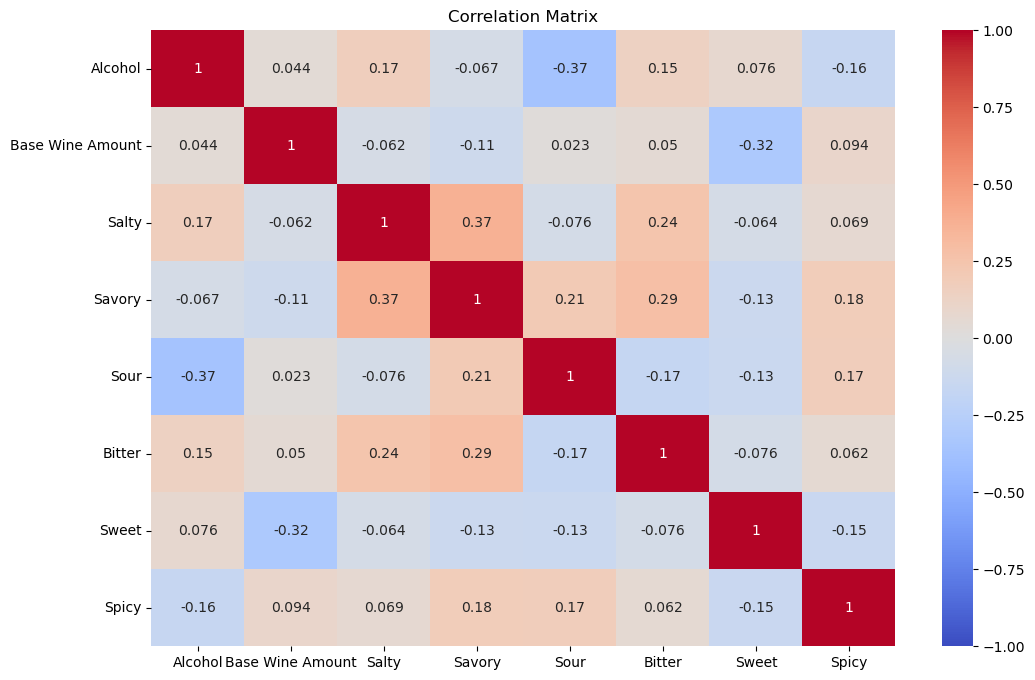

In [229]:
# Plot correlation matrix
# Select only numerical columns
numerical_cols = cocktails_df.select_dtypes(include=[np.number])

# Compute the correlation matrix for numerical columns
corr_matrix = numerical_cols.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

### Handle Missing Values

In [232]:
# Since the cocktails recipes are set there would not be a case to fill in missing values. If the data was truly missing then we would be an associate to fill in the correct information

### Feature Scaling

In [235]:
from sklearn.preprocessing import StandardScaler

# Scale numerical columns
numerical_cols = cocktails_df.select_dtypes(include=['number']).columns
scaler = StandardScaler()
cocktails_df[numerical_cols] = scaler.fit_transform(cocktails_df[numerical_cols])

cocktails_df.head()

,Alcohol,Name,Category,Making,Base Wine,Base Wine Amount,Liquor,Liquor Amount,Juice,Juice Amount,...,Soda Amount,Others,Taste,Type of Glass,Salty,Savory,Sour,Bitter,Sweet,Spicy
0,-1.901512,Tequila Sunset,Short,Blend,Tequila,-1.002448,None,None,Lemon,30,...,None,Ice,Mild,Champagne Saucer,-0.648430,1.235442,1.196735,0.427160,0.462927,-0.145865
1,-1.678624,Chi-Chi,Long,Shake,Vodka,-1.002448,None,None,Pineapple,80,...,None,Coconut Milk,Mild,Armagnac Glasss,-0.648430,1.235442,0.686695,-0.844967,0.462927,-0.145865
2,-1.344292,Sex on the Beach,Long,Build,Vodka,-2.650309,Melon_20/Raspberry_10,30,Pineapple,80,...,None,None,Mild,Highball,-0.648430,-0.809427,1.196735,-0.844967,0.462927,-0.145865
3,-1.344292,Horse’s Neck,Long,Build,Brandy,0.645412,None,None,None,None,...,200,Lemon Piece,Mild,Old Fashioned,0.472585,1.235442,1.196735,-0.844967,-1.012479,-0.145865
4,-1.232848,EL Diablo,Long,Build,Tequila,-1.002448,None,None,None,None,...,250,Orange Piece,Mild,Highball,0.472585,-0.809427,0.144777,0.427160,0.462927,-0.145865


In [237]:
cocktails_df['Name'].unique()

array(['Tequila Sunset', 'Chi-Chi', 'Sex on the Beach', 'Horse’s Neck',
       'EL Diablo', 'Bloody Mary', 'Moscow Mule', 'Cuba Libre',
       'Tequila Sunrise', 'Harvard Cooler', 'Salty Dog', 'John Collins',
       'Gin & Tonic', 'Vodka & Tonic', 'Blue Hawaii', 'Screwdriver',
       'Tom Collins', 'Singapore Sling', 'Havana Beach', 'Imperial Fizz',
       'Long Island Ice Tea', 'Zombie', 'Cosmopolitan', 'Negroni',
       'Mai-Tai', 'Mojito', 'Silk Stockings', 'Mockingbird', 'Margarita',
       'New York', 'Sidecar', 'Gin Fizz', 'Miami Beach', 'Cherry Blossom',
       'Vodka Gimlet', 'Brooklyn', 'Martini Sweet', 'Black Russian',
       'Brave Bull', 'Old Fashioned', 'Manhattan', 'Dirty Mother',
       'Stinger', 'French Connection', 'Martini', 'Godfather',
       'Tequila Martini', 'Earthquake'], dtype=object)

### One-Hot Encode Categorical Variables

In [240]:
# One-Hot Encode categorical columns, except the cocktail name column
categorical_cols = cocktails_df.drop(columns='Name').select_dtypes(include=['object']).columns
cocktails_df = pd.get_dummies(cocktails_df, columns=categorical_cols)

# Convert boolean columns to integers
boolean_cols = cocktails_df.select_dtypes(include=['bool']).columns
cocktails_df[boolean_cols] = cocktails_df[boolean_cols].astype(int)

cocktails_df.head()

,Alcohol,Name,Base Wine Amount,Salty,Savory,Sour,Bitter,Sweet,Spicy,Category_Long,...,Type of Glass_Armagnac Glasss,Type of Glass_Champagne Flute,Type of Glass_Champagne Saucer,Type of Glass_Cognac Ballon,Type of Glass_Cordial Glass,Type of Glass_Highball,Type of Glass_Martini Glass,Type of Glass_Old Fashioned,Type of Glass_Rock,Type of Glass_Shot Glass
0,-1.901512,Tequila Sunset,-1.002448,-0.648430,1.235442,1.196735,0.427160,0.462927,-0.145865,0,...,0,0,1,0,0,0,0,0,0,0
1,-1.678624,Chi-Chi,-1.002448,-0.648430,1.235442,0.686695,-0.844967,0.462927,-0.145865,1,...,1,0,0,0,0,0,0,0,0,0
2,-1.344292,Sex on the Beach,-2.650309,-0.648430,-0.809427,1.196735,-0.844967,0.462927,-0.145865,1,...,0,0,0,0,0,1,0,0,0,0
3,-1.344292,Horse’s Neck,0.645412,0.472585,1.235442,1.196735,-0.844967,-1.012479,-0.145865,1,...,0,0,0,0,0,0,0,1,0,0
4,-1.232848,EL Diablo,-1.002448,0.472585,-0.809427,0.144777,0.427160,0.462927,-0.145865,1,...,0,0,0,0,0,1,0,0,0,0


In [242]:
### Correlation Analysis

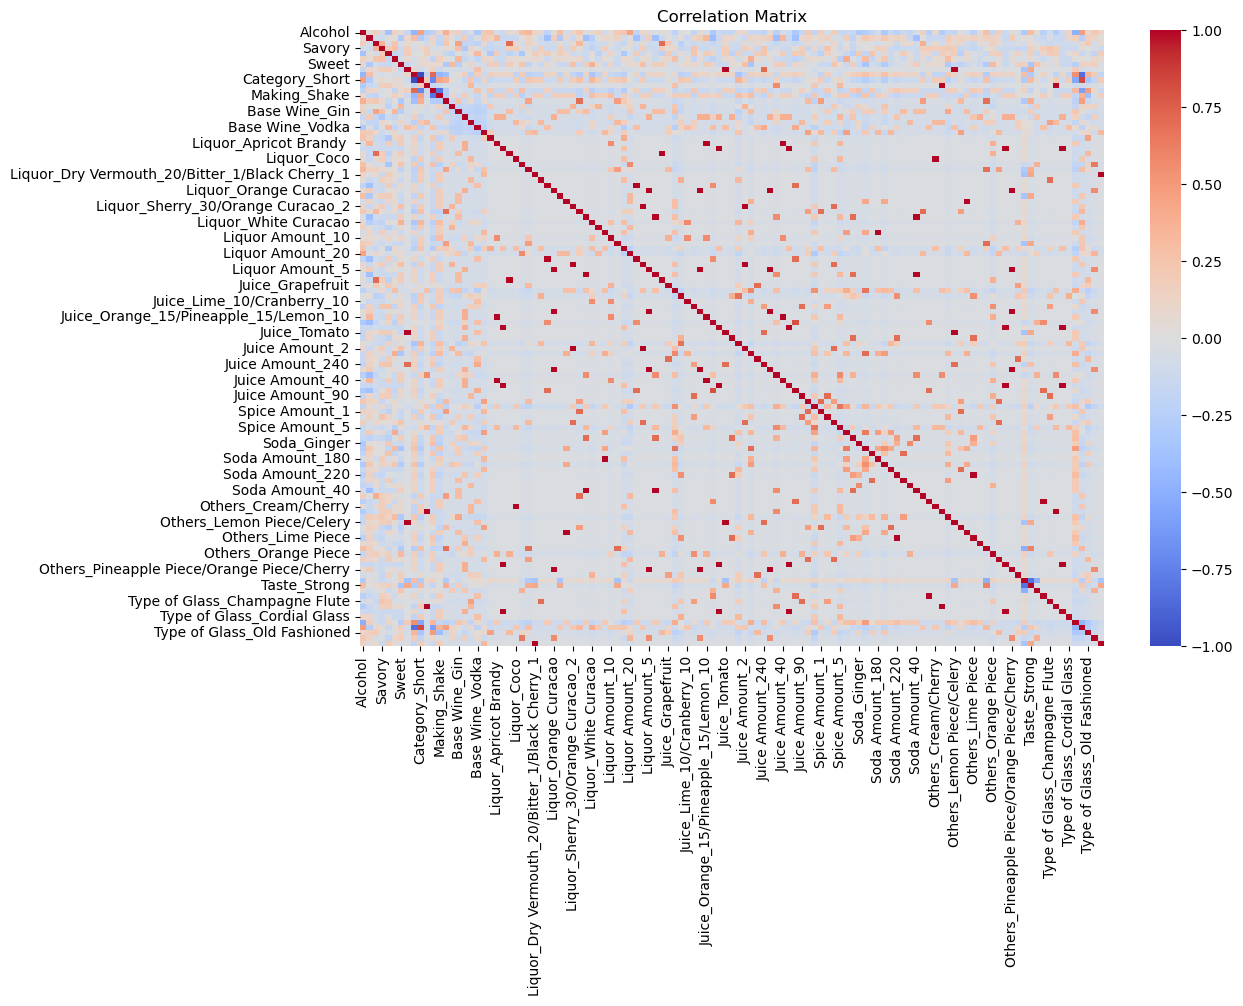

In [244]:
# Plot correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = cocktails_df.drop(columns = 'Name').corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## Synthetic User Rating

In [247]:
## Creating the train/val separately from testing data (like new data in production)

# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split

# cocktail_ids = {name: i for i, name in enumerate(cocktails_df['Name'].unique())}

# # Generate improved synthetic user ratings data
# def generate_synthetic_ratings(num_users, num_ratings):
#     np.random.seed(42)
#     user_ids = np.random.randint(1, num_users + 1, num_ratings)
#     cocktail_names = np.random.choice(cocktails_df['Name'].unique(), num_ratings)
#     user_ratings = np.random.normal(loc=3, scale=1, size=num_ratings).astype(int)
#     user_ratings = np.clip(user_ratings, 1, 5)  # Ensure ratings are between 1 and 5
#     synthetic_data = pd.DataFrame({
#         'user_id': user_ids,
#         'cocktail_name': cocktail_names,
#         'user_rating': user_ratings
#     })

#     synthetic_data['cocktail_id'] = synthetic_data['cocktail_name'].map(cocktail_ids)
    
#     return synthetic_data

# num_users_train_val = 10000  # Number of unique users for training and validation
# num_ratings_train_val = 100000  # Number of ratings for training and validation
# ratings_df_train_val = generate_synthetic_ratings(num_users_train_val, num_ratings_train_val)
# print(ratings_df_train_val.head(10))

# num_users_test = 10000  # Number of unique users for test (upsampling)
# num_ratings_test = 1000  # Number of ratings for test before upsampling
# ratings_df_test = generate_synthetic_ratings(10000, num_ratings_test)

# # Upsample test data to 10000
# ratings_df_test = ratings_df_test.sample(n=10000, replace=True, random_state=42)
# ratings_df_test['user_id'] = np.random.randint(5000, 15001, len(ratings_df_test))

# # Split the training/validation data into 90% train and 10% validation sets
# train_data, val_data = train_test_split(ratings_df_train_val, test_size=0.1, random_state=42)

# print(f"Train data size: {len(train_data)}")
# print(f"Validation data size: {len(val_data)}")
# print(f"Test data size: {len(ratings_df_test)}")

# # Display the first few rows of each set
# print("Training Data:")
# print(train_data.head())

# print("\nValidation Data:")
# print(val_data.head())

# print("\nTest Data:")
# print(ratings_df_test.head())

In [249]:
# ## Generating train/val/test from the same dataset

# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # Assuming 'cocktails_df' is predefined with cocktail names
# cocktail_ids = {name: i for i, name in enumerate(cocktails_df['Name'].unique())}

# # Generate synthetic user ratings data
# def generate_synthetic_ratings(num_users, num_ratings):
#     np.random.seed(42)
#     # user_ids = np.random.randint(1, num_users + 1, num_ratings)
#     user_ids = pd.Series(np.random.randint(1, num_users + 1, num_ratings)).astype(str)
#     # user_ids = "User" + user_ids
#     cocktail_names = np.random.choice(cocktails_df['Name'].unique(), num_ratings)
#     user_ratings = np.random.normal(loc=3, scale=1, size=num_ratings).astype(int)
#     user_ratings = np.clip(user_ratings, 1, 5)  # Ensure ratings are between 1 and 5
#     synthetic_data = pd.DataFrame({
#         'user_id': user_ids,
#         'cocktail_name': cocktail_names,
#         'user_rating': user_ratings
#     })

#     synthetic_data['cocktail_id'] = synthetic_data['cocktail_name'].map(cocktail_ids)
#     synthetic_data['user_email'] = synthetic_data['user_id'].apply(lambda x: f'user{x}@gmail.com')
    
#     return synthetic_data

# num_users = 10000  # Number of unique users
# num_ratings = 100000  # Total number of ratings

# # Generate the data once
# ratings_df = generate_synthetic_ratings(num_users, num_ratings)

# ratings_df.to_csv('user_rating_test.csv', index=False)

# # Split the data into 80% train, 10% validation, and 10% test sets
# train_data, temp_data = train_test_split(ratings_df, test_size=0.2, random_state=42)
# val_data, ratings_df_test = train_test_split(temp_data, test_size=0.5, random_state=42)

# # Print sizes of the splits
# print(f"Train data size: {len(train_data)}")
# print(f"Validation data size: {len(val_data)}")
# print(f"Test data size: {len(test_data)}")

# # Display the first few rows of each set
# print("Training Data:")
# print(train_data.head())

# print("\nValidation Data:")
# print(val_data.head())

# print("\nTest Data:")
# print(ratings_df_test.head())

In [261]:
# Using CTGan User Ratings, generated using colab: User_rating_CTGAN.ipynb

# Assuming 'cocktails_df' is predefined with cocktail names
cocktail_ids = {name: i for i, name in enumerate(cocktails_df['Name'].unique())}

ratings_df = pd.read_csv('user_rating_CTGAN4.csv')
print(ratings_df.columns)
print(ratings_df.head)

ratings_df['cocktail_id'] = ratings_df['cocktail_name'].map(cocktail_ids)
# ratings_df.drop(columns = 'user_email', inplace = True)
print(ratings_df.groupby(['cocktail_name','cocktail_id'])['cocktail_id'].nunique())
      
# Split the data into 80% train, 10% validation, and 10% test sets
train_data, temp_data = train_test_split(ratings_df, test_size=0.2, random_state=42)
val_data, ratings_df_test = train_test_split(temp_data, test_size=0.5, random_state=42)

# Print sizes of the splits
print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(ratings_df_test)}")

# Display the first few rows of each set
print("Training Data:")
print(train_data.head())

print("\nValidation Data:")
print(val_data.head())

print("\nTest Data:")
print(ratings_df_test.head())

Index(['user_id', 'cocktail_name', 'user_rating'], dtype='object')
<bound method NDFrame.head of           user_id    cocktail_name  user_rating
0      3196826377   Tequila Sunset            5
1      8377205875     Havana Beach            5
2      9574596968      Gin & Tonic            3
3      1628602086    Vodka & Tonic            4
4      9130236407    Black Russian            5
...           ...              ...          ...
99995  4114091878  Tequila Martini            3
99996  8377205875      Gin & Tonic            5
99997  6568803961      Bloody Mary            4
99998  6711786895   Tequila Sunset            5
99999  1157027484        Manhattan            4

[100000 rows x 3 columns]>
cocktail_name        cocktail_id
Black Russian        37             1
Bloody Mary          5              1
Blue Hawaii          14             1
Chi-Chi              1              1
Cosmopolitan         22             1
Gin & Tonic          12             1
Godfather            45             1


### Balancing the Dataset

In [266]:
# Apply SMOTE to balance the user rating distribution in the training set
smote = SMOTE(random_state=42)

# Separate features and target variable
X_train = train_data[['user_id', 'cocktail_id']]
y_train = train_data['user_rating']

# Apply SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Combine resampled features and target variable into a new DataFrame
train_data_smote = pd.DataFrame(X_train_smote, columns=['user_id', 'cocktail_id'])
train_data_smote['user_rating'] = y_train_smote

print("\nTraining Data after SMOTE:")
print(train_data_smote.head())

# Check the distribution of ratings in the original and SMOTE datasets
print("\nOriginal Training Data Rating Distribution:")
print(train_data['user_rating'].value_counts())

print("\nSMOTE Training Data Rating Distribution:")
print(train_data_smote['user_rating'].value_counts())

print(f"Train data SMOTE size: {len(train_data_smote)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(ratings_df_test)}")


Training Data after SMOTE:
      user_id  cocktail_id  user_rating
0  1628602086           15            4
1  3196826377           39            1
2  1628602086           25            5
3  9424998611           28            4
4  6918333964           15            4

Original Training Data Rating Distribution:
user_rating
5    42897
4    20237
3     7733
2     5000
1     4133
Name: count, dtype: int64

SMOTE Training Data Rating Distribution:
user_rating
4    42897
1    42897
5    42897
2    42897
3    42897
Name: count, dtype: int64
Train data SMOTE size: 214485
Validation data size: 10000
Test data size: 10000


#### Random Undersampling

In [269]:
# Apply Random Undersampling to the training data
rus = RandomUnderSampler(random_state=42)

# Separate features and target variable for undersampling
X_train = train_data[['user_id', 'cocktail_id']]
y_train = train_data['user_rating']

# Apply Random Undersampling
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Combine undersampled features and target variable into a new DataFrame
train_data_rus = pd.DataFrame(X_train_rus, columns=['user_id', 'cocktail_id'])
train_data_rus['user_rating'] = y_train_rus

print("\nTraining Data after Random Undersampling:")
print(train_data_rus.head())

# Check the distribution of ratings in the original and undersampled datasets
print("\nOriginal Training Data Rating Distribution:")
print(train_data['user_rating'].value_counts())

print("\nRandom Undersampling Training Data Rating Distribution:")
print(train_data_rus['user_rating'].value_counts())

print(f"Train data RUS size: {len(train_data_rus)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(ratings_df_test)}")


Training Data after Random Undersampling:
          user_id  cocktail_id  user_rating
48955  3196826377           39            1
47146  6918333964           15            1
41075  6711786895           44            1
80164  2994916806           14            1
14369  3549260863           18            1

Original Training Data Rating Distribution:
user_rating
5    42897
4    20237
3     7733
2     5000
1     4133
Name: count, dtype: int64

Random Undersampling Training Data Rating Distribution:
user_rating
1    4133
2    4133
3    4133
4    4133
5    4133
Name: count, dtype: int64
Train data RUS size: 20665
Validation data size: 10000
Test data size: 10000


#### SMOTE ontop of RUS

In [272]:
# # Optionally, apply SMOTE after undersampling to balance the data further
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train_rus, y_train_rus)

# # Combine resampled features and target variable into a new DataFrame
# train_data_smote = pd.DataFrame(X_train_smote, columns=['user_id', 'cocktail_id'])
# train_data_smote['user_rating'] = y_train_smote

# print("\nTraining Data after SMOTE:")
# print(train_data_smote.head())

# # Check the distribution of ratings in the SMOTE dataset
# print("\nSMOTE Training Data Rating Distribution:")
# print(train_data_smote['user_rating'].value_counts())

# print(f"Train data RUS size: {len(train_data_rus)}")
# print(f"Validation data size: {len(val_data)}")
# print(f"Test data size: {len(ratings_df_test)}")

In [275]:
# Visualize the distribution

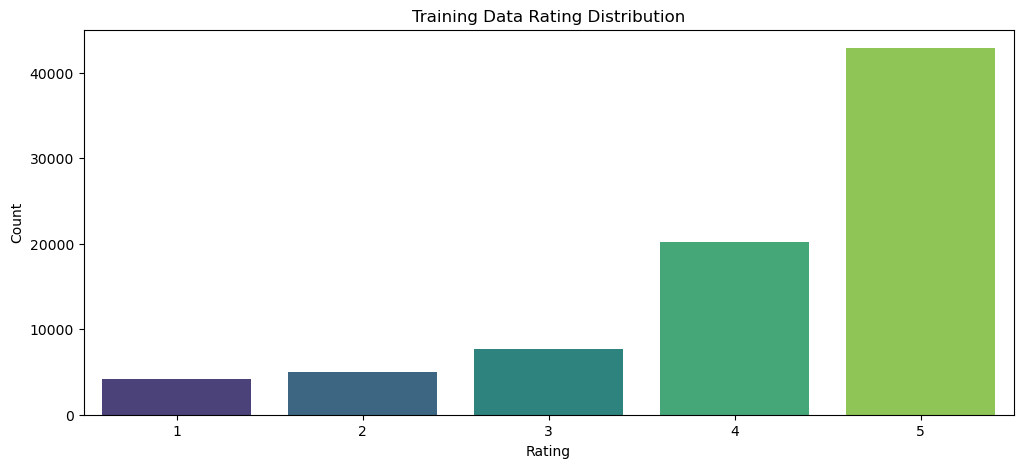

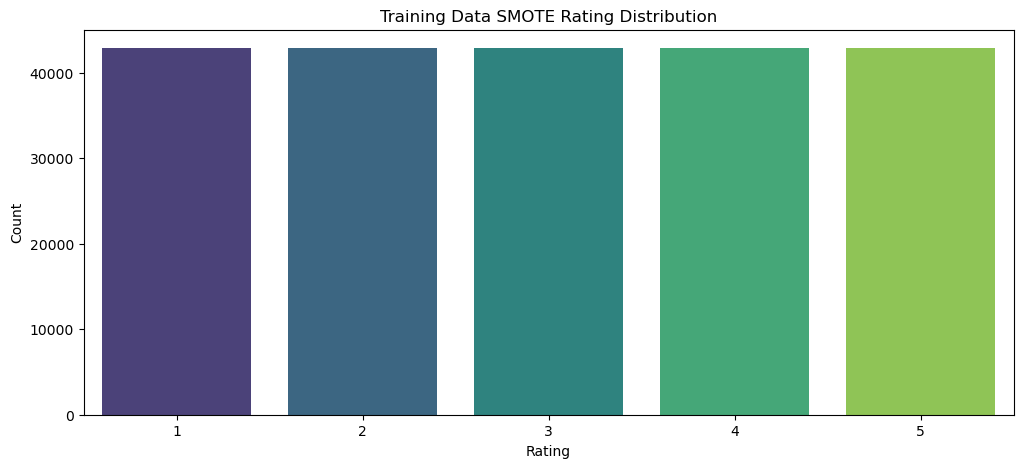

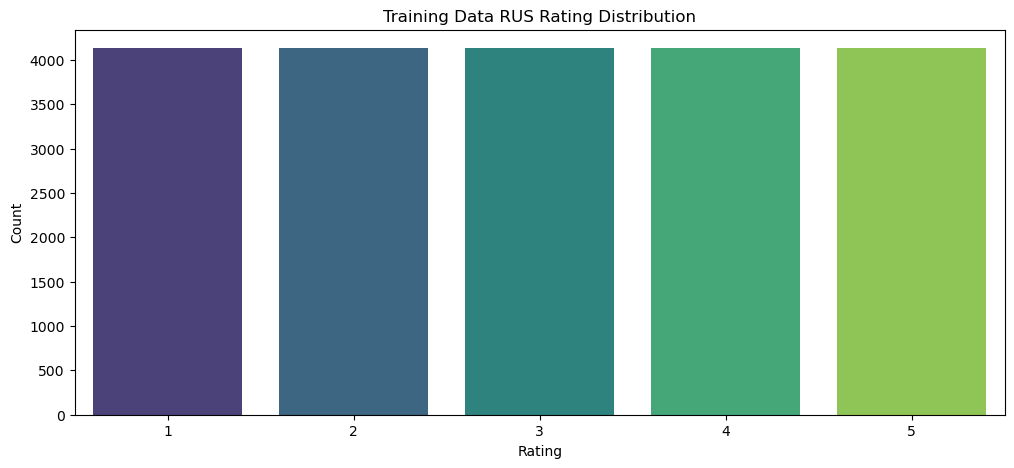

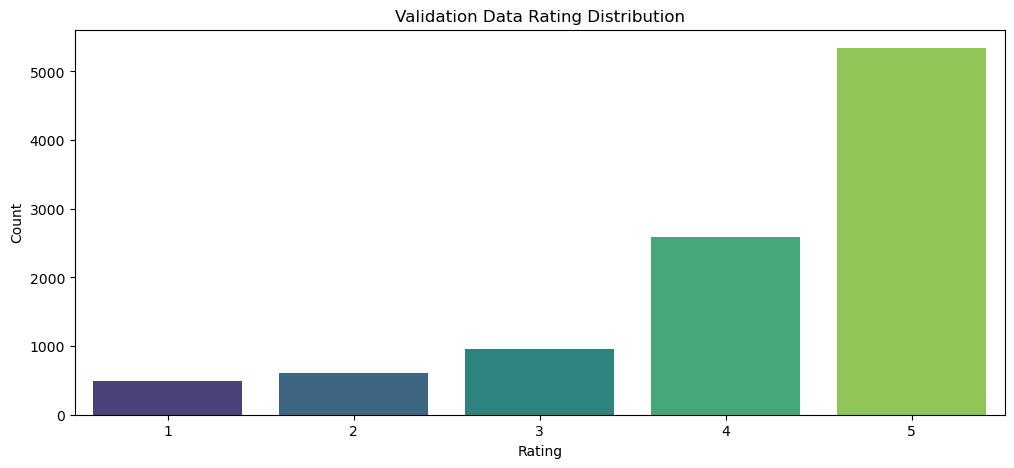

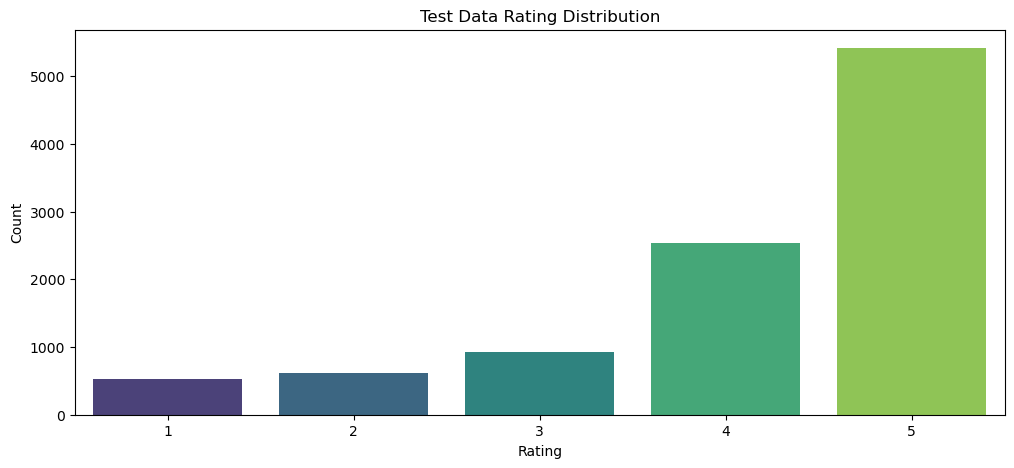

In [277]:
# Function to plot the distribution of ratings
def plot_rating_distribution(df, title):
    plt.figure(figsize=(12, 5))
    rating_counts = df['user_rating'].value_counts().sort_index()
    sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

plot_rating_distribution(train_data, 'Training Data Rating Distribution')
plot_rating_distribution(train_data_smote, 'Training Data SMOTE Rating Distribution')
plot_rating_distribution(train_data_rus, 'Training Data RUS Rating Distribution')
plot_rating_distribution(val_data, 'Validation Data Rating Distribution')
plot_rating_distribution(ratings_df_test, 'Test Data Rating Distribution')

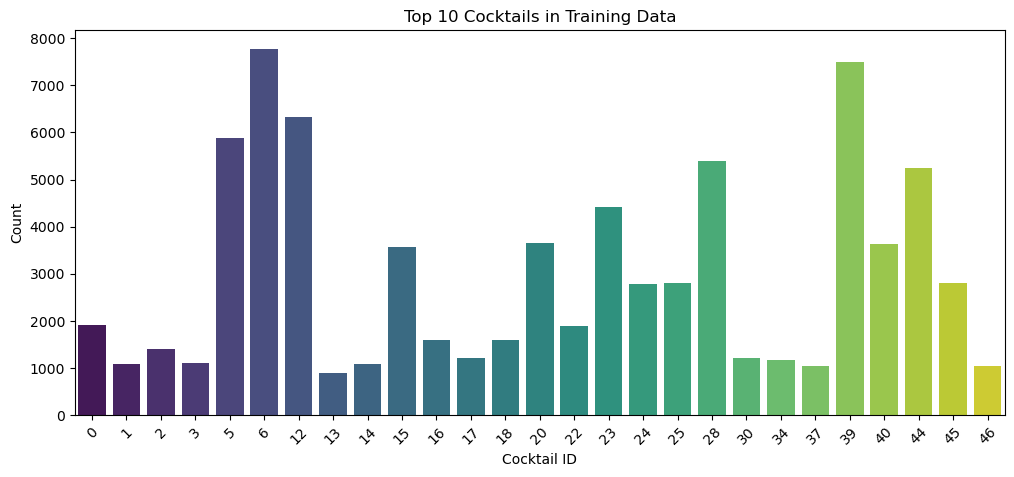

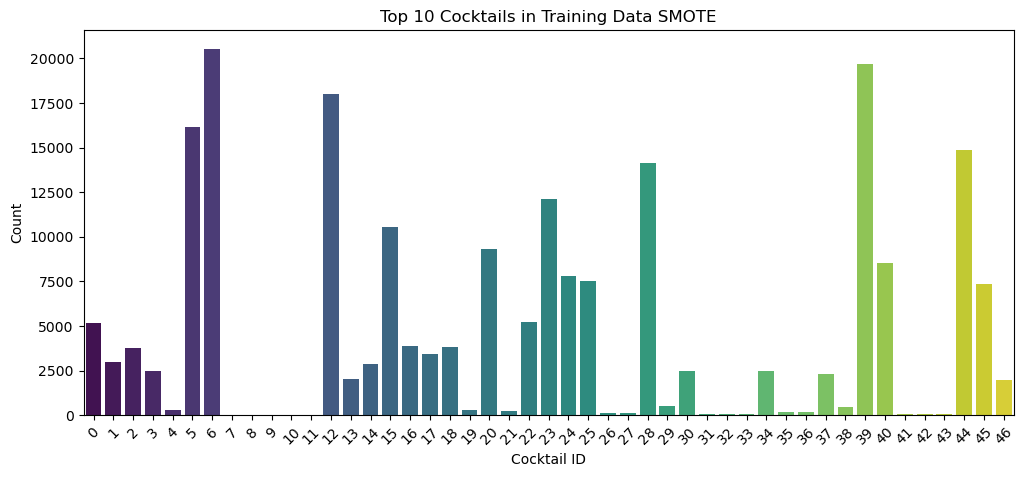

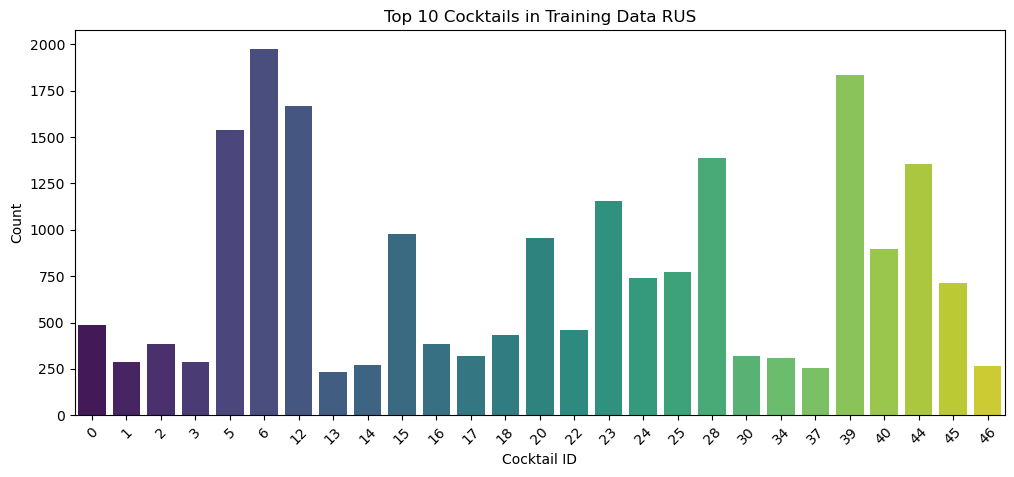

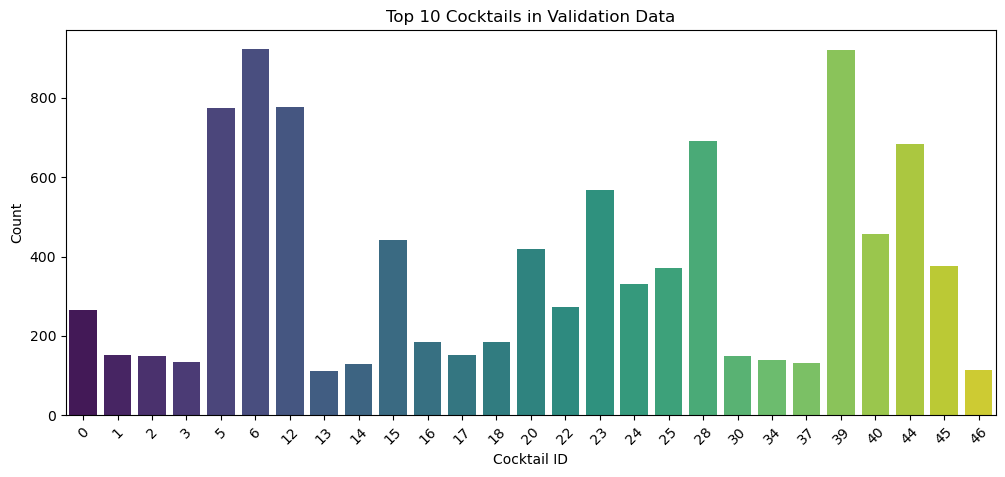

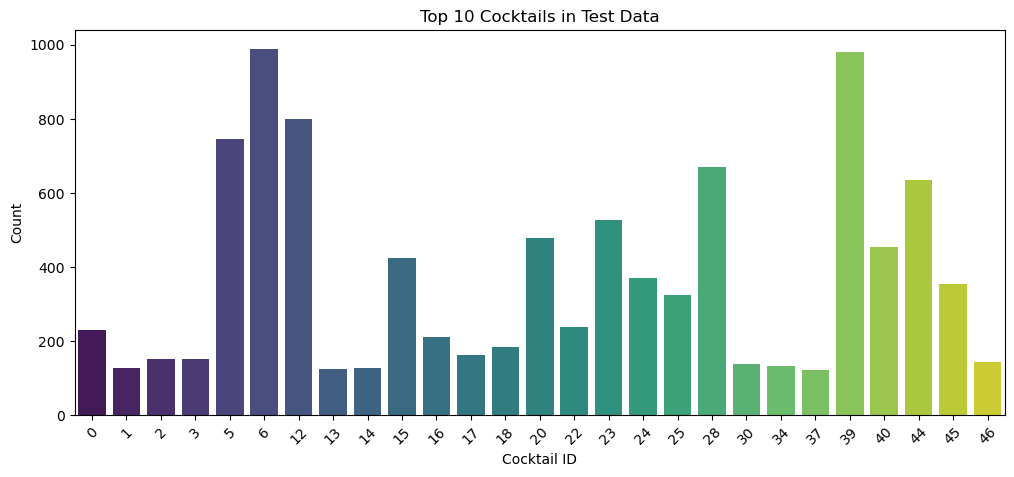

In [279]:
# Function to plot the distribution of cocktails
def plot_cocktail_distribution(df, title):
    plt.figure(figsize=(12, 5))
    cocktail_counts = df['cocktail_id'].value_counts().sort_index()
    sns.barplot(x=cocktail_counts.index, y=cocktail_counts.values, palette='viridis')
    plt.xlabel('Cocktail ID')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_cocktail_distribution(train_data, 'Top 10 Cocktails in Training Data')
plot_cocktail_distribution(train_data_smote, 'Top 10 Cocktails in Training Data SMOTE')
plot_cocktail_distribution(train_data_rus, 'Top 10 Cocktails in Training Data RUS')
plot_cocktail_distribution(val_data, 'Top 10 Cocktails in Validation Data')
plot_cocktail_distribution(ratings_df_test, 'Top 10 Cocktails in Test Data')

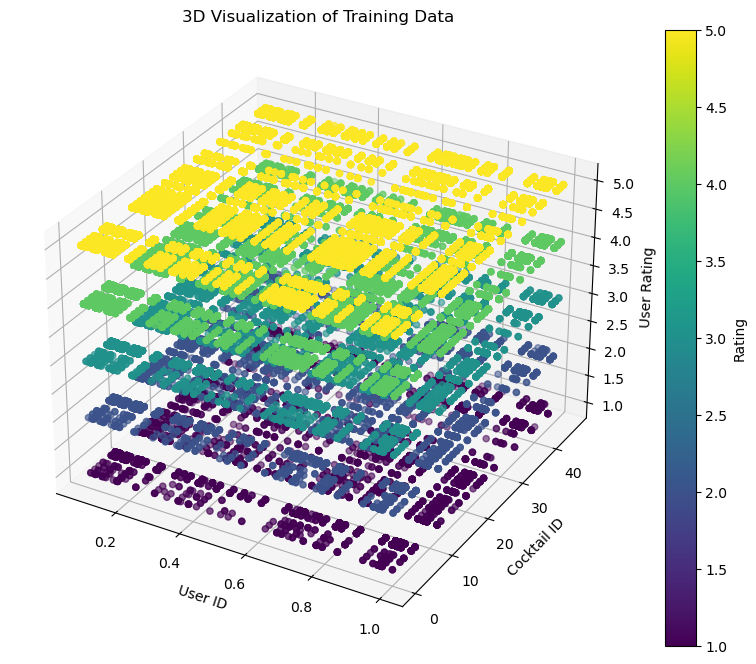

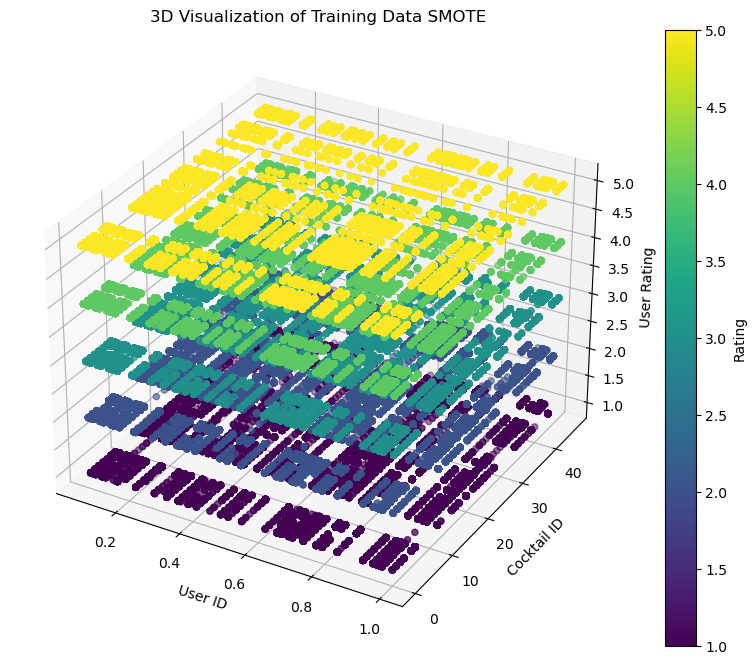

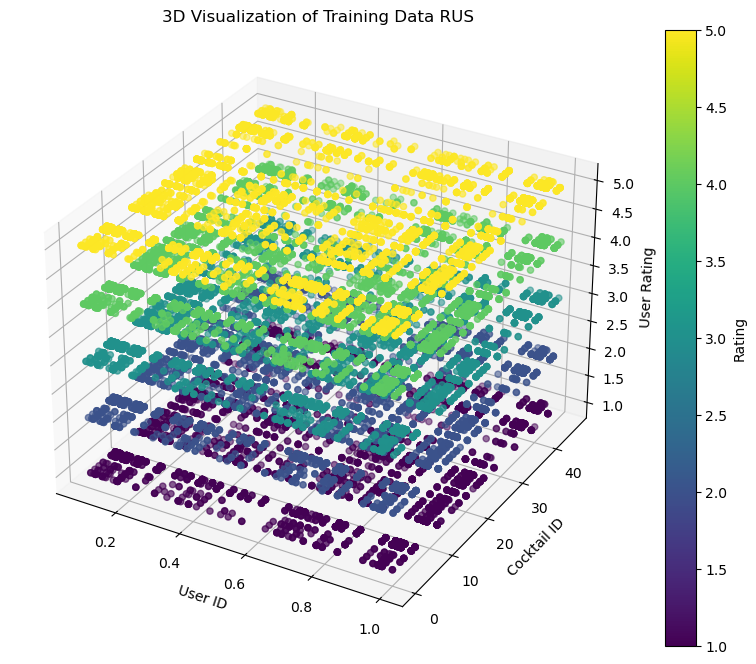

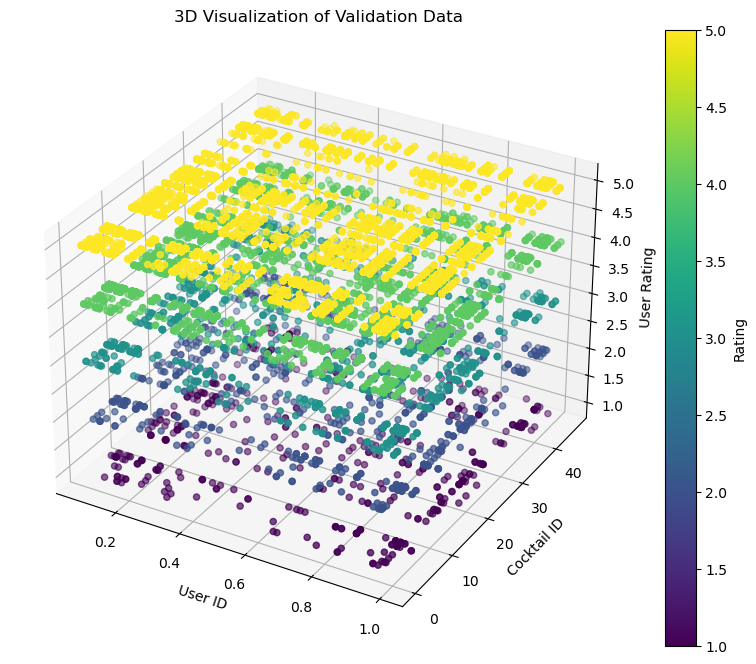

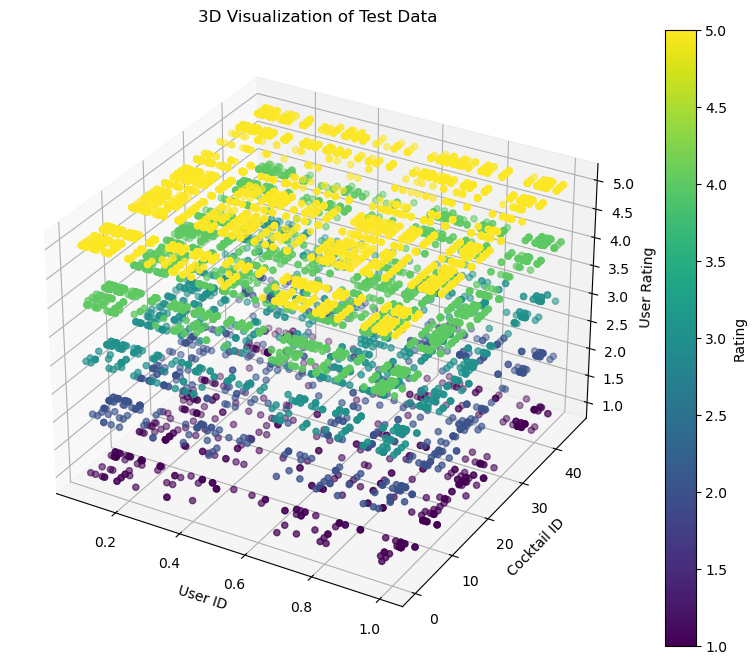

In [281]:
# Encode cocktail names as IDs for plotting
# cocktail_ids = {name: i for i, name in enumerate(cocktails_df['Name'].unique())}
# train_data['cocktail_id'] = train_data['cocktail_name'].map(cocktail_ids)
# val_data['cocktail_id'] = val_data['cocktail_name'].map(cocktail_ids)
# ratings_df_test['cocktail_id'] = ratings_df_test['cocktail_name'].map(cocktail_ids)

# Plotting function
def plot_3d_data(data, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(data['user_id'], data['cocktail_id'], data['user_rating'], c=data['user_rating'], cmap='viridis')
    ax.set_xlabel('User ID')
    ax.set_ylabel('Cocktail ID')
    ax.set_zlabel('User Rating')
    ax.set_title(title)
    plt.colorbar(sc, ax=ax, label='Rating')
    plt.show()

# Plot the training, validation, and test data
plot_3d_data(train_data, '3D Visualization of Training Data')
plot_3d_data(train_data_smote, '3D Visualization of Training Data SMOTE')
plot_3d_data(train_data_rus, '3D Visualization of Training Data RUS')
plot_3d_data(val_data, '3D Visualization of Validation Data')
plot_3d_data(ratings_df_test, '3D Visualization of Test Data')

### Feature Importance

In [344]:
# from sklearn.ensemble import RandomForestRegressor

# # # Prepare the data for feature importance calculation
# # X = cocktails_df.drop(columns='Name')
# # y = np.random.randint(1, 6, len(X))  # Dummy target variable for feature importance

# # # Train a random forest model to compute feature importance
# # rf = RandomForestRegressor()
# # rf.fit(X, y)

# # # Get feature importances
# # importances = rf.feature_importances_
# # feature_names = X.columns
# # feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

# # print(feature_importances.head(10))


# # Merge the cocktails data with the ratings data on cocktail name
# merged_df = ratings_df.merge(cocktails_df, left_on='cocktail_name', right_on='Name')

# print(merged_df.dtypes)
# print(merged_df.columns)

# # Prepare the data for feature importance calculation
# # Use user_rating as the target variable
# X = merged_df.drop(columns=['user_rating', 'Name', 'cocktail_name', 'user_id'])
# y = merged_df['user_rating']


# # # Identify categorical and numerical features
# # categorical_features = ['Category', 'Making', 'Base Wine', 'Liquor', 'Juice', 'Spice', 'Soda', 'Others', 'Taste', 'Type of Glass']
# # numerical_features = ['Alcohol', 'Base Wine Amount', 'Liquor Amount', 'Juice Amount', 'Spice Amount', 'Soda Amount', 'Salty', 'Savory', 'Sour', 'Bitter', 'Sweet', 'Spicy']

# categorical_features = ['cocktail_name']
# numerical_features = merged_df.drop(columns=['cocktail_name']).columns

# # Create a column transformer with one-hot encoding for categorical features
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', 'passthrough', numerical_features),
#         ('cat', OneHotEncoder(), categorical_features)
#     ])

# # Pipeline with preprocessing and random forest regressor
# model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', RandomForestRegressor())
# ])

# # Train the model
# model.fit(X, y)

# # Extract the trained RandomForestRegressor from the pipeline
# rf = model.named_steps['regressor']

# # Get feature importances
# importances = rf.feature_importances_
# feature_names = model.named_steps['preprocessor'].get_feature_names_out()
# feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

# print(feature_importances.head(10))


import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Merge the cocktails data with the ratings data on cocktail name
merged_df = ratings_df.merge(cocktails_df, left_on='cocktail_name', right_on='Name')

# Print data types and columns to check the merge
print(merged_df.dtypes)
print(merged_df.columns)

# Prepare the data for feature importance calculation
# Use user_rating as the target variable
X = merged_df.drop(columns=['user_rating', 'Name', 'cocktail_name', 'user_id'])
y = merged_df['user_rating']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create a column transformer with one-hot encoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Pipeline with preprocessing and random forest regressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Train the model
model.fit(X, y)

# Extract the trained RandomForestRegressor from the pipeline
rf = model.named_steps['regressor']

# Get feature importances
importances = rf.feature_importances_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

print(feature_importances.head(10))


user_id                          int64
cocktail_name                   object
user_rating                      int64
cocktail_id                      int64
Alcohol                        float64
                                ...   
Type of Glass_Highball           int64
Type of Glass_Martini Glass      int64
Type of Glass_Old Fashioned      int64
Type of Glass_Rock               int64
Type of Glass_Shot Glass         int64
Length: 122, dtype: object
Index(['user_id', 'cocktail_name', 'user_rating', 'cocktail_id', 'Alcohol',
       'Name', 'Base Wine Amount', 'Salty', 'Savory', 'Sour',
       ...
       'Type of Glass_Armagnac Glasss', 'Type of Glass_Champagne Flute',
       'Type of Glass_Champagne Saucer', 'Type of Glass_Cognac Ballon',
       'Type of Glass_Cordial Glass', 'Type of Glass_Highball',
       'Type of Glass_Martini Glass', 'Type of Glass_Old Fashioned',
       'Type of Glass_Rock', 'Type of Glass_Shot Glass'],
      dtype='object', length=122)
                         

## Building Recommendation Models

### Similarity Scores

In [96]:
# print(cocktails_df.columns)
# print(cocktails_df.dtypes)
# cocktails_df.head()

In [304]:
# Identify categorical and numerical columns
categorical_cols = cocktails_df.select_dtypes(include=['object', 'bool']).columns.difference(['Name'])
numerical_cols = cocktails_df.select_dtypes(include=[np.number]).columns

# Define the preprocessing steps for categorical and numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Apply the transformations
transformed_features = preprocessor.fit_transform(cocktails_df)

# Compute the cosine similarity between all pairs of cocktails
similarity_matrix = cosine_similarity(transformed_features)

# Create a DataFrame to display similarities nicely
similarity_df = pd.DataFrame(similarity_matrix, index=cocktails_df['Name'], columns=cocktails_df['Name'])
# print(similarity_df)

# Convert DataFrame to Series and sort values in descending order
sorted_pairs = similarity_df.unstack().sort_values(ascending=False).dropna()
# print(sorted_pairs)

# Remove self-similarities by setting them to NaN
sorted_pairs[sorted_pairs == 1] = np.nan
sorted_pairs = sorted_pairs.dropna()

# # Map cocktail_id to cocktail_name in sorted_pairs
sorted_pairs.index = sorted_pairs.index.set_names(['Cocktail Name 1', 'Cocktail Name 2'])
sorted_pairs = sorted_pairs.reset_index()
sorted_pairs.rename(columns={0: 'Similarity Score'}, inplace=True)

# Remove entries with the same names
sorted_pairs = sorted_pairs[sorted_pairs['Cocktail Name 1'] != sorted_pairs['Cocktail Name 2']]

# Ensure each pair is considered only once by sorting the cocktail names within each pair
sorted_pairs[['Cocktail Name 1', 'Cocktail Name 2']] = np.sort(sorted_pairs[['Cocktail Name 1', 'Cocktail Name 2']], axis=1)

# Remove duplicate pairs
sorted_pairs = sorted_pairs.drop_duplicates(subset=['Cocktail Name 1', 'Cocktail Name 2'])

# Print the pairs in descending order of similarity score
print(sorted_pairs)

# Save the similarity DataFrame to a CSV file
similarity_df.to_csv('cocktail_similarity_df.csv', index=True)

        Cocktail Name 1  Cocktail Name 2  Similarity Score
45    French Connection        Godfather          0.851795
47              Martini  Tequila Martini          0.663750
49        Black Russian     Dirty Mother          0.628521
51        Black Russian       Brave Bull          0.607774
53            Margarita          Sidecar          0.582504
...                 ...              ...               ...
2291             Mojito          Sidecar         -0.199517
2293         Brave Bull      Tom Collins         -0.214562
2295          Margarita      Tom Collins         -0.228098
2297       Horse’s Neck         New York         -0.231982
2299           Gin Fizz        Margarita         -0.255449

[1128 rows x 3 columns]


### Content-based Filtering

In [307]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between cocktails based on their features
cocktail_features = cocktails_df.set_index('Name')
# print(cocktail_features)
similarity_matrix = cosine_similarity(cocktail_features)
# print(similarity_matrix)

# Create a recommendation function
def recommend_cocktails(cocktail_name, similarity_matrix, cocktail_names, top_n):
    idx = cocktail_names.index(cocktail_name)
    print(idx)
    similarity_scores = list(enumerate(similarity_matrix[idx]))
    # print(similarity_scores)
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    # print(similarity_scores)
    recommended_cocktails = [cocktail_names[i[0]] for i in similarity_scores[1:top_n+1]]
    # print(recommended_cocktails)
    return recommended_cocktails

# Test the recommendation function
cocktail_names = cocktails_df['Name'].tolist()
cocktail_name = 'Margarita'  # Replace this with any cocktail from the dataset
num_of_recs = 5

recommended_cocktails = recommend_cocktails(cocktail_name, similarity_matrix, cocktail_names, num_of_recs)

# Print the recommended cocktails
print("Recommended cocktails similar to a", cocktail_name, ":")
print(recommended_cocktails)


28
Recommended cocktails similar to a Margarita :
['Sidecar', 'New York', 'Cosmopolitan', 'Stinger', 'Havana Beach']


### Collaborative Filtering

In [310]:
import pandas as pd
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split

# Define the data reader
reader = Reader(rating_scale=(1, 5))

# Prepare training, validation, and test sets for the `surprise` library
train_data_surprise = Dataset.load_from_df(train_data[['user_id', 'cocktail_id', 'user_rating']], reader)
# train_data_surprise = Dataset.load_from_df(train_data_smote[['user_id', 'cocktail_id', 'user_rating']], reader)
# train_data_surprise = Dataset.load_from_df(train_data_rus[['user_id', 'cocktail_id', 'user_rating']], reader)
val_data_surprise = Dataset.load_from_df(val_data[['user_id', 'cocktail_id', 'user_rating']], reader)
test_data_surprise = Dataset.load_from_df(ratings_df_test[['user_id', 'cocktail_id', 'user_rating']], reader)

# # Build the full training set
trainset = train_data_surprise.build_full_trainset()

# Convert validation and test sets to the required format
valset = val_data_surprise.construct_testset(val_data_surprise.raw_ratings)
testset = test_data_surprise.construct_testset(test_data_surprise.raw_ratings)

In [312]:
# Train an SVD model
svd = SVD()
svd.fit(trainset)

# Evaluate the model on the validation set
val_predictions = svd.test(valset)
val_rmse = accuracy.rmse(val_predictions, verbose=True)

# # Final evaluation on the test set
# test_predictions = svd.test(testset)
# test_rmse = accuracy.rmse(test_predictions, verbose=True)

print(f"Validation RMSE: {val_rmse}")
# print(f"Test RMSE: {test_rmse}")

RMSE: 1.1386
Validation RMSE: 1.1385581322467502


In [314]:
# # Final evaluation on the test set
# test_predictions = svd.test(testset)
# test_rmse = accuracy.rmse(test_predictions, verbose=True)

# # print(f"Validation RMSE: {val_rmse}")
# print(f"Test RMSE: {test_rmse}")

Explanation
Data Preparation:

We use the surprise library's Dataset and Reader classes to load the train, validation, and test sets.
The data is converted into a format suitable for the surprise library.
Training the Model:

We use the SVD algorithm, a popular choice for collaborative filtering.
The model is trained on the full training set.
Evaluating the Model:

We use the validation set to tune the model and compute the RMSE (Root Mean Squared Error) to check the model's performance.
Finally, we evaluate the model on the test set and compute the RMSE to assess its generalization performance.
This approach ensures that the collaborative filtering model is trained on the training set, tuned on the validation set, and evaluated on the test set, providing a robust assessment of its performance.

#### Random Search for Hyperparameter Tuning

In [318]:
# from surprise import SVD
# from surprise.model_selection import RandomizedSearchCV
# import numpy as np

# # Define the parameter grid for random search
# param_grid = {
#     'n_factors': [20, 50, 100, 150],
#     'n_epochs': [10, 20, 30, 40],
#     'lr_all': [0.002, 0.005, 0.007, 0.01],
#     'reg_all': [0.02, 0.05, 0.1, 0.2]
# }

# # Define the number of iterations for random search
# n_iter = 20

# # Perform Randomized Search
# rs = RandomizedSearchCV(SVD, param_distributions=param_grid, measures=['rmse'], cv=3, n_iter=n_iter, random_state=42)
# rs.fit(train_data_surprise)

# # Get the best parameters
# best_params = rs.best_params['rmse']
# print("Best parameters: ", best_params)

# # Use the best parameters to train the final model
# best_svd = rs.best_estimator['rmse']
# best_svd.fit(trainset)

# # Evaluate on validation and test sets
# val_predictions = best_svd.test(valset)
# val_rmse = accuracy.rmse(val_predictions, verbose=True)

# # test_predictions = best_svd.test(testset)
# # test_rmse = accuracy.rmse(test_predictions, verbose=True)

# print(f"Validation RMSE: {val_rmse}")
# # print(f"Test RMSE: {test_rmse}")

In [320]:
# test_predictions = best_svd.test(testset)
# test_rmse = accuracy.rmse(test_predictions, verbose=True)

# # print(f"Validation RMSE: {val_rmse}")
# print(f"Test RMSE: {test_rmse}")

#### Checking for Overfitting or Underfitting (Best SVD lr_all=0.005, reg_all=0.02)

In [323]:
# # Function to train SVD model and record RMSE at each epoch
# def train_svd_with_learning_curves(trainset, valset, n_epochs, n_factors=100, lr_all=0.005, reg_all=0.02):
#     train_errors = []
#     val_errors = []
    
#     svd = SVD(n_factors=n_factors, lr_all=lr_all, reg_all=reg_all, n_epochs=1)  # Initialize SVD with n_epochs=1 to control manually
    
#     for epoch in range(n_epochs):
#         svd.n_epochs = epoch + 1
#         svd.fit(trainset)  # Incremental training
        
#         # Calculate RMSE for training set
#         train_predictions = svd.test(trainset.build_testset())
#         train_rmse = accuracy.rmse(train_predictions, verbose=False)
#         train_errors.append(train_rmse)
        
#         # Calculate RMSE for validation set
#         val_predictions = svd.test(valset)
#         val_rmse = accuracy.rmse(val_predictions, verbose=False)
#         val_errors.append(val_rmse)
        
#         print(f"Epoch {epoch + 1}/{n_epochs} - Training RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")
    
#     return train_errors, val_errors

# # Train the model and record learning curves
# n_epochs = 20
# train_errors, val_errors = train_svd_with_learning_curves(trainset, valset, n_epochs)

# # Plot the learning curves
# def plot_learning_curves(train_errors, val_errors):
#     plt.figure(figsize=(10, 6))
#     plt.plot(range(1, n_epochs + 1), train_errors, label='Training Error')
#     plt.plot(range(1, n_epochs + 1), val_errors, label='Validation Error')
#     plt.xlabel('Epochs')
#     plt.ylabel('RMSE')
#     plt.title('Learning Curves')
#     plt.legend()
#     plt.show()

# plot_learning_curves(train_errors, val_errors)

In [325]:
# The learning curves in the provided plot, along with the RMSE values over the epochs, provide insights into how the model is performing during training and on the validation set. Here's what the learning curves tell us:

# ### Analysis

# 1. **Training RMSE Decrease**:
#    - The training RMSE decreases steadily over the epochs, indicating that the model is learning and fitting the training data better with each epoch.
#    - By the 20th epoch, the training RMSE has significantly decreased to around 0.6805, showing that the model has learned the patterns in the training data well.

# 2. **Validation RMSE Increase**:
#    - The validation RMSE initially fluctuates slightly but then starts to increase after a few epochs.
#    - By the 20th epoch, the validation RMSE has increased to around 1.0387.

# ### Interpretation

# - **Overfitting**:
#   - The increasing gap between the training RMSE and validation RMSE indicates overfitting. The model is performing well on the training data but is not generalizing well to the validation data.
#   - The validation error increases despite the training error decreasing, which is a classic sign of overfitting.

# - **Model Complexity**:
#   - The model may be too complex for the data, capturing noise and specific patterns in the training data that do not generalize to unseen data.

# ### Recommendations

# To address overfitting, consider the following strategies:

# 1. **Increase Regularization**:
#    - Increase the regularization parameter (`reg_all`) to penalize large weights and reduce overfitting.
#    - For example, you might try increasing `reg_all` to 0.1 or 0.2.

# 2. **Early Stopping**:
#    - Use early stopping to halt training when the validation error starts to increase. This can prevent the model from overfitting to the training data.

# 3. **Reduce Model Complexity**:
#    - Reduce the number of latent factors (`n_factors`) to simplify the model and make it less prone to overfitting.

# 4. **Cross-Validation**:
#    - Use cross-validation to ensure the model's performance is consistent across different subsets of the data.

# 5. **Ensemble Methods**:
#    - Combine predictions from multiple models to reduce the impact of overfitting.

# ### Example of Adjusting Hyperparameters

# ```python
# # Train the model with increased regularization and reduced number of factors
# svd = SVD(n_factors=50, lr_all=0.005, reg_all=0.1, n_epochs=20)
# svd.fit(trainset)

# # Evaluate the model on the validation set
# val_predictions = svd.test(valset)
# val_rmse = accuracy.rmse(val_predictions, verbose=True)
# print(f"Validation RMSE after regularization adjustment: {val_rmse}")
# ```

# By adjusting these hyperparameters and potentially using early stopping, you can help mitigate overfitting and improve the model's generalization to the validation (and test) data.

#### Checking for Overfitting or Underfitting (Best SVD lr_all=0.002, reg_all=0.05)

In [328]:
# # Function to train SVD model and record RMSE at each epoch using the best hyperparameters
# def train_svd_with_learning_curves(trainset, valset, n_epochs, n_factors=50, lr_all=0.002, reg_all=0.05):
#     train_errors = []
#     val_errors = []
    
#     svd = SVD(n_factors=n_factors, lr_all=lr_all, reg_all=reg_all, n_epochs=1)  # Initialize SVD with n_epochs=1 to control manually
    
#     for epoch in range(n_epochs):
#         svd.n_epochs = epoch + 1
#         svd.fit(trainset)  # Incremental training
        
#         # Calculate RMSE for training set
#         train_predictions = svd.test(trainset.build_testset())
#         train_rmse = accuracy.rmse(train_predictions, verbose=False)
#         train_errors.append(train_rmse)
        
#         # Calculate RMSE for validation set
#         val_predictions = svd.test(valset)
#         val_rmse = accuracy.rmse(val_predictions, verbose=False)
#         val_errors.append(val_rmse)
        
#         print(f"Epoch {epoch + 1}/{n_epochs} - Training RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")
    
#     return train_errors, val_errors

# # Train the model and record learning curves using the best hyperparameters
# n_epochs = 20
# train_errors, val_errors = train_svd_with_learning_curves(trainset, valset, n_epochs, n_factors=50, lr_all=0.002, reg_all=0.05)

# # Plot the learning curves
# def plot_learning_curves(train_errors, val_errors):
#     plt.figure(figsize=(10, 6))
#     plt.plot(range(1, n_epochs + 1), train_errors, label='Training Error')
#     plt.plot(range(1, n_epochs + 1), val_errors, label='Validation Error')
#     plt.xlabel('Epochs')
#     plt.ylabel('RMSE')
#     plt.title('Learning Curves')
#     plt.legend()
#     plt.show()

# plot_learning_curves(train_errors, val_errors)


Analysis
Training RMSE:

The training RMSE decreases steadily over the epochs, indicating that the model continues to improve its fit to the training data. By the 20th epoch, the training RMSE has decreased significantly.
Validation RMSE:

The validation RMSE starts relatively high and remains fairly constant with minor fluctuations. This indicates that the model's performance on the validation set is not improving significantly over time.
Interpretation
Overfitting:
The decreasing training RMSE and relatively constant validation RMSE indicate that the model is overfitting. The model is learning the training data well, but this is not translating to improved performance on the validation set.
The training error continues to decrease, but the validation error does not follow the same trend, which suggests that the model is memorizing the training data rather than generalizing from it.

#### Checking for Overfitting or Underfitting (Best SVD lr_all=0.002, reg_all=0.1)

In [332]:
# # Function to train SVD model and record RMSE at each epoch using the best hyperparameters
# def train_svd_with_learning_curves(trainset, valset, n_epochs, n_factors=50, lr_all=0.002, reg_all=0.1):
#     train_errors = []
#     val_errors = []
    
#     svd = SVD(n_factors=n_factors, lr_all=lr_all, reg_all=reg_all, n_epochs=1)  # Initialize SVD with n_epochs=1 to control manually
    
#     for epoch in range(n_epochs):
#         svd.n_epochs = epoch + 1
#         svd.fit(trainset)  # Incremental training
        
#         # Calculate RMSE for training set
#         train_predictions = svd.test(trainset.build_testset())
#         train_rmse = accuracy.rmse(train_predictions, verbose=False)
#         train_errors.append(train_rmse)
        
#         # Calculate RMSE for validation set
#         val_predictions = svd.test(valset)
#         val_rmse = accuracy.rmse(val_predictions, verbose=False)
#         val_errors.append(val_rmse)
        
#         print(f"Epoch {epoch + 1}/{n_epochs} - Training RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")
    
#     return train_errors, val_errors

# # Train the model and record learning curves using the best hyperparameters with increased regularization
# n_epochs = 20
# train_errors, val_errors = train_svd_with_learning_curves(trainset, valset, n_epochs, n_factors=50, lr_all=0.002, reg_all=0.1)

# # Plot the learning curves
# def plot_learning_curves(train_errors, val_errors):
#     plt.figure(figsize=(10, 6))
#     plt.plot(range(1, n_epochs + 1), train_errors, label='Training Error')
#     plt.plot(range(1, n_epochs + 1), val_errors, label='Validation Error')
#     plt.xlabel('Epochs')
#     plt.ylabel('RMSE')
#     plt.title('Learning Curves')
#     plt.legend()
#     plt.show()

# plot_learning_curves(train_errors, val_errors)

In [334]:
# def apply_smote(train_data):
#     smote = SMOTE(random_state=42)
#     X_train = train_data[['user_id', 'cocktail_id']]
#     y_train = train_data['user_rating']
#     X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
#     train_data_smote = pd.DataFrame(X_train_smote, columns=['user_id', 'cocktail_id'])
#     train_data_smote['user_rating'] = y_train_smote
#     return train_data_smote

# def apply_rus(train_data):
#     rus = RandomUnderSampler(random_state=42)
#     X_train = train_data[['user_id', 'cocktail_id']]
#     y_train = train_data['user_rating']
#     X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
#     train_data_rus = pd.DataFrame(X_train_rus, columns=['user_id', 'cocktail_id'])
#     train_data_rus['user_rating'] = y_train_rus
#     return train_data_rus


In [336]:
def train_and_evaluate_svd(train_data, val_data, param_grid, n_iter=20):
    reader = Reader(rating_scale=(1, 5))
    train_data_surprise = Dataset.load_from_df(train_data[['user_id', 'cocktail_id', 'user_rating']], reader)
    # val_data_surprise = Dataset.load_from_df(val_data[['user_id', 'cocktail_id', 'user_rating']], reader)
    
    trainset = train_data_surprise.build_full_trainset()
    # valset = val_data_surprise.construct_testset(val_data_surprise.raw_ratings)
    
    rs = RandomizedSearchCV(SVD, param_distributions=param_grid, measures=['rmse'], cv=3, n_iter=n_iter, random_state=42)
    rs.fit(train_data_surprise)
    
    best_params = rs.best_params['rmse']
    best_svd = rs.best_estimator['rmse']
    best_svd.fit(trainset)
    
    val_predictions = best_svd.test(valset)
    val_rmse = accuracy.rmse(val_predictions, verbose=True)
    
    return best_svd, best_params, val_rmse

In [338]:
def plot_learning_curves(train_errors, val_errors, title, filename):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_errors) + 1), train_errors, label='Training Error')
    plt.plot(range(1, len(val_errors) + 1), val_errors, label='Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title(title)
    plt.legend()
    plt.savefig(filename)
    plt.show()

In [340]:
def train_svd_with_learning_curves(trainset, valset, n_epochs, params):
    train_errors = []
    val_errors = []
    svd = SVD(n_factors=params['n_factors'], lr_all=params['lr_all'], reg_all=params['reg_all'], n_epochs=1)
    
    for epoch in range(n_epochs):
        svd.n_epochs = epoch + 1
        svd.fit(trainset)
        
        train_predictions = svd.test(trainset.build_testset())
        train_rmse = accuracy.rmse(train_predictions, verbose=False)
        train_errors.append(train_rmse)
        
        val_predictions = svd.test(valset)
        val_rmse = accuracy.rmse(val_predictions, verbose=False)
        val_errors.append(val_rmse)
        
        print(f"Epoch {epoch + 1}/{n_epochs} - Training RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")
    
    return train_errors, val_errors

In [342]:
# Define parameter grid for random search
param_grid = {
    'n_factors': [20, 50, 100, 150],
    'n_epochs': [10, 20, 30, 40],
    'lr_all': [0.002, 0.005, 0.007, 0.01],
    'reg_all': [0.02, 0.05, 0.1, 0.2]
}

# # Apply SMote and Random Undersampling
# train_data_smote = apply_smote(train_data)
# train_data_rus = apply_rus(train_data)

# Store results
results = []

# Evaluate with original data
print("Evaluating with Original Data:")
best_svd_orig, best_params_orig, val_rmse_orig = train_and_evaluate_svd(train_data, val_data, param_grid)
results.append(('Original', best_params_orig, val_rmse_orig))

# Evaluate with SMOTE data
print("Evaluating with SMOTE Data:")
best_svd_smote, best_params_smote, val_rmse_smote = train_and_evaluate_svd(train_data_smote, val_data, param_grid)
results.append(('SMOTE', best_params_smote, val_rmse_smote))

# Evaluate with Random Undersampling data
print("Evaluating with RUS Data:")
best_svd_rus, best_params_rus, val_rmse_rus = train_and_evaluate_svd(train_data_rus, val_data, param_grid)
results.append(('RUS', best_params_rus, val_rmse_rus))

# Create a DataFrame to compare results
results_df = pd.DataFrame(results, columns=['Method', 'Best Params', 'Validation RMSE'])
print(results_df)


Evaluating with Original Data:


TypeError: RandomizedSearchCV.__init__() got an unexpected keyword argument 'measures'

In [ ]:
# results_df.to_csv('model_evaluation.csv', index = False)


Training and plotting learning curves for Original Data:
Epoch 1/50 - Training RMSE: 0.9870, Validation RMSE: 0.9883
Epoch 2/50 - Training RMSE: 0.9845, Validation RMSE: 0.9878
Epoch 3/50 - Training RMSE: 0.9822, Validation RMSE: 0.9884
Epoch 4/50 - Training RMSE: 0.9803, Validation RMSE: 0.9887
Epoch 5/50 - Training RMSE: 0.9783, Validation RMSE: 0.9883
Epoch 6/50 - Training RMSE: 0.9766, Validation RMSE: 0.9881
Epoch 7/50 - Training RMSE: 0.9748, Validation RMSE: 0.9888
Epoch 8/50 - Training RMSE: 0.9734, Validation RMSE: 0.9890
Epoch 9/50 - Training RMSE: 0.9717, Validation RMSE: 0.9889
Epoch 10/50 - Training RMSE: 0.9700, Validation RMSE: 0.9894
Epoch 11/50 - Training RMSE: 0.9684, Validation RMSE: 0.9899
Epoch 12/50 - Training RMSE: 0.9673, Validation RMSE: 0.9901
Epoch 13/50 - Training RMSE: 0.9657, Validation RMSE: 0.9902
Epoch 14/50 - Training RMSE: 0.9644, Validation RMSE: 0.9904
Epoch 15/50 - Training RMSE: 0.9629, Validation RMSE: 0.9906
Epoch 16/50 - Training RMSE: 0.9617,

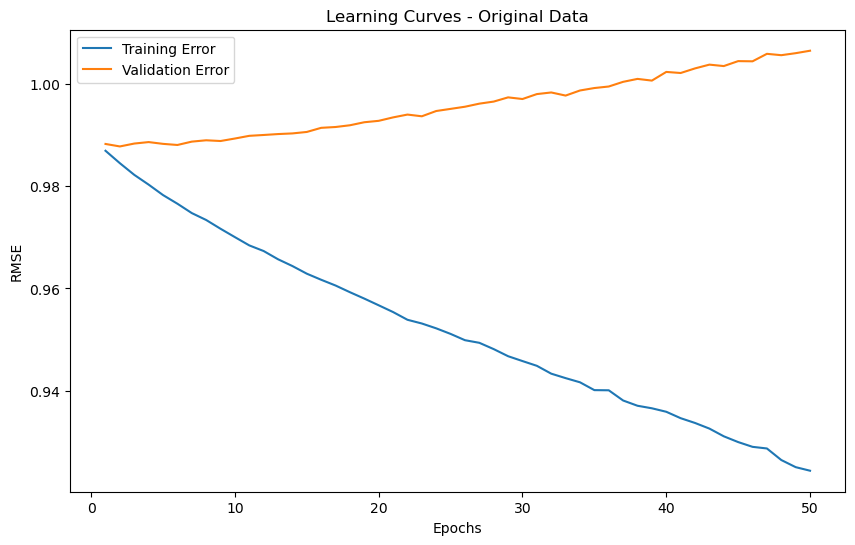


Training and plotting learning curves for SMOTE Data:
Epoch 1/50 - Training RMSE: 1.3879, Validation RMSE: 1.1589
Epoch 2/50 - Training RMSE: 1.3678, Validation RMSE: 1.1583
Epoch 3/50 - Training RMSE: 1.3507, Validation RMSE: 1.1590
Epoch 4/50 - Training RMSE: 1.3347, Validation RMSE: 1.1608
Epoch 5/50 - Training RMSE: 1.3212, Validation RMSE: 1.1640
Epoch 6/50 - Training RMSE: 1.3052, Validation RMSE: 1.1649
Epoch 7/50 - Training RMSE: 1.2880, Validation RMSE: 1.1661
Epoch 8/50 - Training RMSE: 1.2730, Validation RMSE: 1.1694
Epoch 9/50 - Training RMSE: 1.2539, Validation RMSE: 1.1705
Epoch 10/50 - Training RMSE: 1.2336, Validation RMSE: 1.1725
Epoch 11/50 - Training RMSE: 1.2130, Validation RMSE: 1.1747
Epoch 12/50 - Training RMSE: 1.1920, Validation RMSE: 1.1776
Epoch 13/50 - Training RMSE: 1.1641, Validation RMSE: 1.1779
Epoch 14/50 - Training RMSE: 1.1417, Validation RMSE: 1.1802
Epoch 15/50 - Training RMSE: 1.1152, Validation RMSE: 1.1799
Epoch 16/50 - Training RMSE: 1.0879, Va

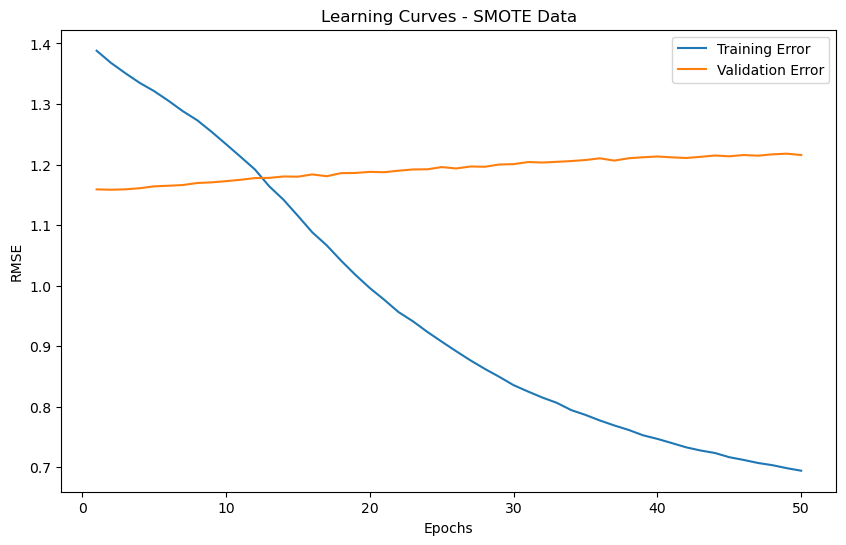


Training and plotting learning curves for RUS Data:
Epoch 1/50 - Training RMSE: 1.4099, Validation RMSE: 1.1097
Epoch 2/50 - Training RMSE: 1.4058, Validation RMSE: 1.1211
Epoch 3/50 - Training RMSE: 1.4019, Validation RMSE: 1.1287
Epoch 4/50 - Training RMSE: 1.3994, Validation RMSE: 1.1328
Epoch 5/50 - Training RMSE: 1.3962, Validation RMSE: 1.1373
Epoch 6/50 - Training RMSE: 1.3924, Validation RMSE: 1.1394
Epoch 7/50 - Training RMSE: 1.3897, Validation RMSE: 1.1407
Epoch 8/50 - Training RMSE: 1.3864, Validation RMSE: 1.1419
Epoch 9/50 - Training RMSE: 1.3842, Validation RMSE: 1.1418
Epoch 10/50 - Training RMSE: 1.3791, Validation RMSE: 1.1424
Epoch 11/50 - Training RMSE: 1.3760, Validation RMSE: 1.1429
Epoch 12/50 - Training RMSE: 1.3732, Validation RMSE: 1.1429
Epoch 13/50 - Training RMSE: 1.3707, Validation RMSE: 1.1426
Epoch 14/50 - Training RMSE: 1.3671, Validation RMSE: 1.1432
Epoch 15/50 - Training RMSE: 1.3639, Validation RMSE: 1.1430
Epoch 16/50 - Training RMSE: 1.3602, Vali

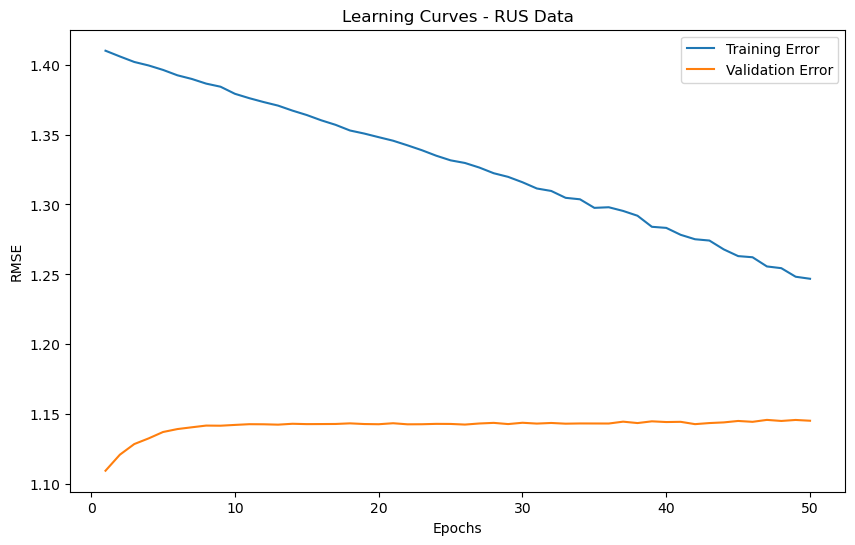

In [103]:
n_epochs = 50

# Original Data
print("\nTraining and plotting learning curves for Original Data:")
train_data_surprise = Dataset.load_from_df(train_data[['user_id', 'cocktail_id', 'user_rating']], reader)
trainset = train_data_surprise.build_full_trainset()
valset = val_data_surprise.construct_testset(val_data_surprise.raw_ratings)
train_errors, val_errors = train_svd_with_learning_curves(trainset, valset, n_epochs, best_params_orig)
plot_learning_curves(train_errors, val_errors, "Learning Curves - Original Data", "learning_curves_original.png")

# SMOTE Data
print("\nTraining and plotting learning curves for SMOTE Data:")
train_data_surprise = Dataset.load_from_df(train_data_smote[['user_id', 'cocktail_id', 'user_rating']], reader)
trainset = train_data_surprise.build_full_trainset()
valset = val_data_surprise.construct_testset(val_data_surprise.raw_ratings)
train_errors, val_errors = train_svd_with_learning_curves(trainset, valset, n_epochs, best_params_smote)
plot_learning_curves(train_errors, val_errors, "Learning Curves - SMOTE Data", "learning_curves_smote.png")

# RUS Data
print("\nTraining and plotting learning curves for RUS Data:")
train_data_surprise = Dataset.load_from_df(train_data_rus[['user_id', 'cocktail_id', 'user_rating']], reader)
trainset = train_data_surprise.build_full_trainset()
valset = val_data_surprise.construct_testset(val_data_surprise.raw_ratings)
train_errors, val_errors = train_svd_with_learning_curves(trainset, valset, n_epochs, best_params_rus)
plot_learning_curves(train_errors, val_errors, "Learning Curves - RUS Data", "learning_curves_rus.png")

<!-- https://beckernick.github.io/matrix-factorization-recommender/ -->

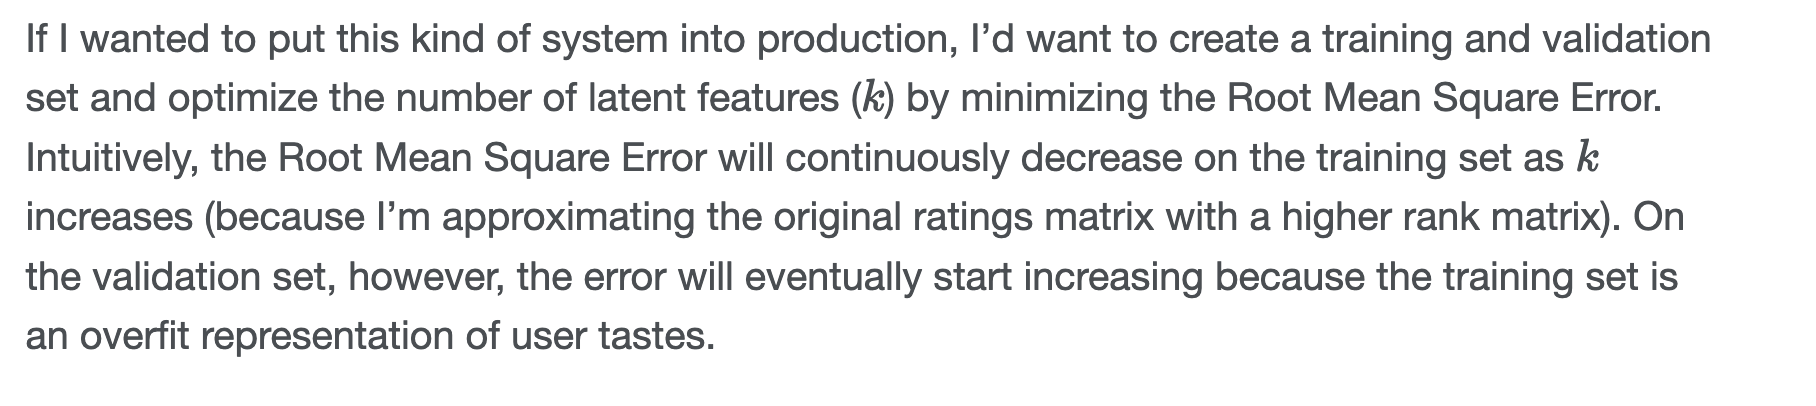



In [ ]:
# def evaluate_on_test_data(model, test_data):
#     reader = Reader(rating_scale=(1, 5))
#     test_data_surprise = Dataset.load_from_df(test_data[['user_id', 'cocktail_id', 'user_rating']], reader)
#     testset = test_data_surprise.construct_testset(test_data_surprise.raw_ratings)
#     test_predictions = model.test(testset)
#     test_rmse = accuracy.rmse(test_predictions, verbose=True)
#     return test_rmse

# # Evaluate the best models on the test set
# print("\nEvaluating best models on the test set:")

# test_rmse_orig = evaluate_on_test_data(best_svd_orig, ratings_df_test)
# print(f"Test RMSE (Original): {test_rmse_orig}")

# test_rmse_smote = evaluate_on_test_data(best_svd_smote, ratings_df_test)
# print(f"Test RMSE (SMOTE): {test_rmse_smote}")

# test_rmse_rus = evaluate_on_test_data(best_svd_rus, ratings_df_test)
# print(f"Test RMSE (RUS): {test_rmse_rus}")


In [ ]:
# # Ideal curve should look like:
# import matplotlib.pyplot as plt
# import numpy as np

# epochs = np.arange(1, 21)
# train_error = np.exp(-0.2 * epochs) + 0.1
# val_error = np.exp(-0.2 * epochs) + 0.15

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_error, label='Training Error')
# plt.plot(epochs, val_error, label='Validation Error')
# plt.xlabel('Epochs')
# plt.ylabel('Error')
# plt.title('Ideal Learning Curves')
# plt.legend()
# plt.show()




#### Using the SVD model

In [93]:
# Get a list of all unique cocktails
all_cocktails = cocktails_df['Name'].unique()

num_cocktails_to_rec = 5

# Function to get the top N recommendations for a given user
def get_top_n_recommendations(model, user_id, all_cocktails, n=num_cocktails_to_rec):
    # Get a list of cocktails the user has already rated
    rated_cocktails = set(train_data[train_data['user_id'] == user_id]['cocktail_name'])
    
    # Predict ratings for all cocktails the user hasn't rated yet
    predictions = []
    for cocktail in all_cocktails:
        if cocktail not in rated_cocktails:
            predictions.append((cocktail, model.predict(user_id, cocktail).est))
    
    # Sort the predictions by estimated rating in descending order and get the top N recommendations
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_n_recommendations = predictions[:n]
    
    return top_n_recommendations

# Function to get cocktails already rated by a given user
def get_rated_cocktails(user_id, data):
    rated_cocktails = data[data['user_id'] == user_id][['cocktail_name', 'user_rating']].sort_values('user_rating',ascending = False)
    return rated_cocktails

# Get recommendations for users 1 through 5
for user_id in range(1, 6):
    rated_cocktails = get_rated_cocktails(user_id, train_data)
    print(f"Cocktails rated by user {user_id}:")
    print(rated_cocktails.head(5))
    print()

    recommendations = get_top_n_recommendations(svd, user_id, all_cocktails)
    print(f"Top recommendations for user {user_id}:")
    for cocktail, rating in recommendations:
        print(f"  {cocktail}: {rating:.2f}")
    print()

Cocktails rated by user 1:
       cocktail_name  user_rating
44543    Miami Beach            3
83407    Tom Collins            3
56543    Blue Hawaii            3
71841  Black Russian            2
15191   Dirty Mother            2

Top recommendations for user 1:
  Tequila Sunset: 2.31
  Sex on the Beach: 2.31
  EL Diablo: 2.31
  Bloody Mary: 2.31
  Moscow Mule: 2.31

Cocktails rated by user 2:
         cocktail_name  user_rating
76599   Silk Stockings            5
21207  Tequila Sunrise            4
94362     Dirty Mother            3
1695    Harvard Cooler            3
17806          Mai-Tai            3

Top recommendations for user 2:
  Tequila Sunset: 2.40
  Chi-Chi: 2.40
  Sex on the Beach: 2.40
  Horse’s Neck: 2.40
  EL Diablo: 2.40

Cocktails rated by user 3:
        cocktail_name  user_rating
25917         Mai-Tai            4
88924     Moscow Mule            3
79897     Blue Hawaii            3
39003  Tequila Sunset            3
4006    Black Russian            3

Top recomme

#### Using the best_svd model

In [94]:
# Get a list of all unique cocktails
all_cocktails = cocktails_df['Name'].unique()

num_cocktails_to_rec = 5

# Function to get the top N recommendations for a given user
def get_top_n_recommendations(model, user_id, all_cocktails, n=num_cocktails_to_rec):
    # Get a list of cocktails the user has already rated
    rated_cocktails = set(train_data[train_data['user_id'] == user_id]['cocktail_name'])
    
    # Predict ratings for all cocktails the user hasn't rated yet
    predictions = []
    for cocktail in all_cocktails:
        if cocktail not in rated_cocktails:
            predictions.append((cocktail, model.predict(user_id, cocktail).est))
    
    # Sort the predictions by estimated rating in descending order and get the top N recommendations
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_n_recommendations = predictions[:n]
    
    return top_n_recommendations

# Function to get cocktails already rated by a given user
def get_rated_cocktails(user_id, data):
    rated_cocktails = data[data['user_id'] == user_id][['cocktail_name', 'user_rating']].sort_values('user_rating',ascending = False)
    return rated_cocktails

# Get recommendations for users 1 through 5
for user_id in range(1, 6):
    rated_cocktails = get_rated_cocktails(user_id, train_data)
    print(f"Cocktails rated by user {user_id}:")
    print(rated_cocktails.head(5))
    print()

    recommendations = get_top_n_recommendations(best_svd, user_id, all_cocktails)
    print(f"Top recommendations for user {user_id}:")
    for cocktail, rating in recommendations:
        print(f"  {cocktail}: {rating:.2f}")
    print()

Cocktails rated by user 1:
       cocktail_name  user_rating
44543    Miami Beach            3
83407    Tom Collins            3
56543    Blue Hawaii            3
71841  Black Russian            2
15191   Dirty Mother            2

Top recommendations for user 1:
  Tequila Sunset: 2.42
  Sex on the Beach: 2.42
  EL Diablo: 2.42
  Bloody Mary: 2.42
  Moscow Mule: 2.42

Cocktails rated by user 2:
         cocktail_name  user_rating
76599   Silk Stockings            5
21207  Tequila Sunrise            4
94362     Dirty Mother            3
1695    Harvard Cooler            3
17806          Mai-Tai            3

Top recommendations for user 2:
  Tequila Sunset: 2.46
  Chi-Chi: 2.46
  Sex on the Beach: 2.46
  Horse’s Neck: 2.46
  EL Diablo: 2.46

Cocktails rated by user 3:
        cocktail_name  user_rating
25917         Mai-Tai            4
88924     Moscow Mule            3
79897     Blue Hawaii            3
39003  Tequila Sunset            3
4006    Black Russian            3

Top recomme

In [ ]:
from pptx import Presentation
from pptx.util import Inches

# Create a presentation object
prs = Presentation()

# Add a title slide
slide = prs.slides.add_slide(prs.slide_layouts[0])
title = slide.shapes.title
subtitle = slide.placeholders[1]
title.text = "Cocktail Recommendation System"
subtitle.text = "A Machine Learning Project\nYour Name\nDate"

# Add slides for each section
sections = [
    "Problem Statement", "Assumptions and Hypotheses", "Exploratory Data Analysis",
    "Feature Engineering", "Model Approaches", "Model Selection",
    "Results", "Learnings", "Future Work"
]

for section in sections:
    slide = prs.slides.add_slide(prs.slide_layouts[1])
    title = slide.shapes.title
    content = slide.placeholders[1]
    title.text = section
    content.text = f"Content for {section} slide."

# Save the presentation
prs.save('Cocktail_Recommendation_System.pptx')

In [ ]:
# Deep Learning

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.optimizers import Adam

# Assuming the same fake ratings dataframe from the earlier example
# For demonstration, we're reusing the 'ratings_df' created earlier

# Encoding user IDs and cocktail names
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings_df['user_id_encoded'] = user_encoder.fit_transform(ratings_df['user_id'])
ratings_df['item_id_encoded'] = item_encoder.fit_transform(ratings_df['item_id'])

# Splitting the data
X = ratings_df[['user_id_encoded', 'item_id_encoded']]
y = ratings_df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Neural network architecture
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

user_embedding = Embedding(output_dim=5, input_dim=len(user_encoder.classes_), name='user_embedding')(user_input)
item_embedding = Embedding(output_dim=5, input_dim=len(item_encoder.classes_), name='item_embedding')(item_input)

user_vec = Flatten(name='flatten_users')(user_embedding)
item_vec = Flatten(name='flatten_items')(item_embedding)

concat = Concatenate()([user_vec, item_vec])
fc1 = Dense(128, activation='relu')(concat)
output = Dense(1)(fc1)

model = Model([user_input, item_input], output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit([X_train['user_id_encoded'], X_train['item_id_encoded']], y_train, epochs=10, verbose=1, validation_split=0.1)

# Evaluate the model
model.evaluate([X_test['user_id_encoded'], X_test['item_id_encoded']], y_test)


In [ ]:
def make_recommendations(user_id, num_recommendations=5):
    user_idx = user_encoder.transform([user_id])[0]
    all_cocktails_idx = np.array(list(set(ratings_df['item_id_encoded'])))
    user_idx_array = np.array([user_idx for _ in range(len(all_cocktails_idx))])
    predictions = model.predict([user_idx_array, all_cocktails_idx])
    top_ratings_indices = predictions.flatten().argsort()[-num_recommendations:][::-1]
    top_cocktail_ids = item_encoder.inverse_transform(all_cocktails_idx[top_ratings_indices])
    return top_cocktail_ids

# Test recommendations for a user
print("Top recommendations for a user:", make_recommendations('User5'))

In [ ]:
def make_batch_recommendations(user_ids, num_recommendations=5):
    # Transform user_ids to indices
    user_idx = user_encoder.transform(user_ids)
    # Get all cocktails indices
    all_cocktails_idx = np.array(list(set(ratings_df['item_id_encoded'])))
    # Prepare the batch data
    user_idx_array = np.tile(user_idx[:, np.newaxis], (1, len(all_cocktails_idx))).flatten()
    all_cocktails_idx_array = np.tile(all_cocktails_idx, len(user_idx))
    
    # Predict ratings for all combinations
    predictions = model.predict([user_idx_array, all_cocktails_idx_array]).flatten()
    # Reshape predictions to match the number of users and items
    predictions_matrix = predictions.reshape(len(user_idx), len(all_cocktails_idx))
    
    # Get the top recommendations for each user
    top_ratings_indices = np.argsort(predictions_matrix, axis=1)[:, -num_recommendations:]
    
    # Iterate over each user's top indices and decode the cocktail names
    recommendations = {}
    for i, indices in enumerate(top_ratings_indices):
        top_cocktail_ids = item_encoder.inverse_transform(all_cocktails_idx[indices])
        recommendations[user_ids[i]] = top_cocktail_ids

    return recommendations

# Example: Recommend cocktails for multiple users
user_list = ['User1', 'User2', 'User3']
recommendations = make_batch_recommendations(user_list)
for user, recs in recommendations.items():
    print(f"Top recommendations for {user}: {recs}")

In [ ]:
ratings_df

In [ ]:
import seaborn as sns
from sklearn.decomposition import PCA

# Use PCA to reduce dimensionality of embeddings for visualization
def visualize_embeddings(embeddings, labels):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels)
    plt.title('PCA on Embeddings')
    plt.show()

# Visualizing user and item embeddings
user_embeddings = model.get_layer('user_embedding').get_weights()[0]
item_embeddings = model.get_layer('item_embedding').get_weights()[0]
visualize_embeddings(user_embeddings, user_encoder.inverse_transform(range(len(user_encoder.classes_))))
visualize_embeddings(item_embeddings, item_encoder.inverse_transform(range(len(item_encoder.classes_))))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Function to plot embeddings using t-SNE
def plot_embeddings(embeddings, names, title):
    tsne = TSNE(n_components=2, random_state=42)
    components = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 6))
    plt.scatter(components[:, 0], components[:, 1])
    for i, name in enumerate(names):
        plt.annotate(name, (components[i, 0], components[i, 1]))
    plt.title(title)
    plt.grid(True)
    plt.show()

# Extract embeddings
user_embeddings = model.get_layer('user_embedding').get_weights()[0]
item_embeddings = model.get_layer('item_embedding').get_weights()[0]

# Get names for annotations
user_names = user_encoder.inverse_transform(range(len(user_encoder.classes_)))
item_names = item_encoder.inverse_transform(range(len(item_encoder.classes_)))

# Plotting
plot_embeddings(user_embeddings, user_names, 'User Embeddings')
plot_embeddings(item_embeddings, item_names, 'Item (Cocktail) Embeddings')


In [ ]:
# Analyze the dense layer weights
fc1_weights = model.get_layer('dense').get_weights()[0]

# Sum absolute weights to see which input features (post-embedding) have the most influence
feature_importance = np.sum(np.abs(fc1_weights), axis=1)

# Plot feature importance
plt.bar(range(len(feature_importance)), feature_importance)
plt.title('Feature Importance in Dense Layer')
plt.xlabel('Feature Index')
plt.ylabel('Sum of Absolute Weights')
plt.show()

In [ ]:
# Here's an example implementation of NCF using TensorFlow/Keras:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the dataset
cocktails_file_path = 'cocktails.csv'
cocktails_df = pd.read_csv(cocktails_file_path)

# Replace all cells with '-' with null (None)
cocktails_df.replace('-', None, inplace=True)

# Label encode categorical columns
label_encoders = {}
categorical_cols = cocktails_df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    cocktails_df[col] = le.fit_transform(cocktails_df[col].astype(str))
    label_encoders[col] = le

# Generate synthetic user ratings data
def generate_synthetic_ratings(num_records):
    user_ids = np.random.randint(1, 1001, num_records)
    cocktail_names = np.random.choice(cocktails_df['Name'].unique(), num_records)
    user_ratings = np.random.randint(1, 6, num_records)
    synthetic_data = pd.DataFrame({
        'user_id': user_ids,
        'cocktail_name': cocktail_names,
        'user_rating': user_ratings
    })
    return synthetic_data

num_records = 1000  # Change this number to generate different sizes of datasets
ratings_df = generate_synthetic_ratings(num_records)

# Create a mapping from cocktail names to indices
cocktail_map = {name: idx for idx, name in enumerate(cocktails_df['Name'].unique())}

# Add a column for cocktail indices
ratings_df['cocktail_idx'] = ratings_df['cocktail_name'].map(cocktail_map)

# Ensure user_id and cocktail_idx are within valid range
max_user_id = ratings_df['user_id'].max()
max_cocktail_idx = ratings_df['cocktail_idx'].max()

num_users = max_user_id + 1
num_cocktails = max_cocktail_idx + 1

# Define the NCF model
def create_ncf_model(num_users, num_cocktails, embedding_dim=50, layers=[128, 64, 32]):
    # Input layers
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')
    
    # Embedding layers
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
    item_embedding = Embedding(input_dim=num_cocktails, output_dim=embedding_dim, name='item_embedding')(item_input)
    
    # Flatten the embeddings
    user_flatten = Flatten()(user_embedding)
    item_flatten = Flatten()(item_embedding)
    
    # Concatenate user and item embeddings
    concatenated = Concatenate()([user_flatten, item_flatten])
    
    # Fully connected layers
    x = concatenated
    for layer_size in layers:
        x = Dense(layer_size, activation='relu')(x)
        x = Dropout(0.2)(x)
    
    # Output layer
    output = Dense(1, activation='sigmoid')(x)
    
    # Create the model
    model = Model(inputs=[user_input, item_input], outputs=output)
    return model

# Create the NCF model
embedding_dim = 50
layers = [128, 64, 32]
ncf_model = create_ncf_model(num_users, num_cocktails, embedding_dim, layers)

# Compile the model
ncf_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])

# Prepare data for training
X = [ratings_df['user_id'].values, ratings_df['cocktail_idx'].values]
y = ratings_df['user_rating'].values

# Split data into train and test sets
user_train, user_test, cocktail_train, cocktail_test, y_train, y_test = train_test_split(X[0], X[1], y, test_size=0.2, random_state=42)

# Train the model
ncf_model.fit([user_train, cocktail_train], y_train, epochs=10, batch_size=64, validation_data=([user_test, cocktail_test], y_test))

# Evaluate the model
loss, accuracy = ncf_model.evaluate([user_test, cocktail_test], y_test)
print(f"Test Accuracy: {accuracy}")
